# Exploratory Analysis and Assumptions in the Fashion MNIST Dataset

[Back to Main](../Project.ipynb)

## Introduction to the Fashion MNIST Dataset
The Fashion MNIST dataset is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. The dataset serves as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. The original MNIST dataset contains a lot of handwritten digits. Members of the AI/ML/Data Science community love this dataset and use it as a benchmark to validate their algorithms. In fact, MNIST is often the first dataset researchers try. "If it doesn't work on MNIST, it won't work at all", they said. "Well, if it does work on MNIST, it may still fail on others." - [Yann LeCun](http://yann.lecun.com/exdb/mnist/)


#### Import Necessary Libraries and Load the Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import fashion_mnist
import statsmodels.api as sm
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans
import keras
import pandas as pd
from sklearn.metrics import silhouette_score

# Loading the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

This code will load the Fashion MNIST dataset and print the shapes of the training and testing data.

In [2]:
# Print the shapes of the data
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)



### Visualizing Some Images from the Dataset

To better understand the nature of images in the dataset, let's visualize a few sample images along with their labels.


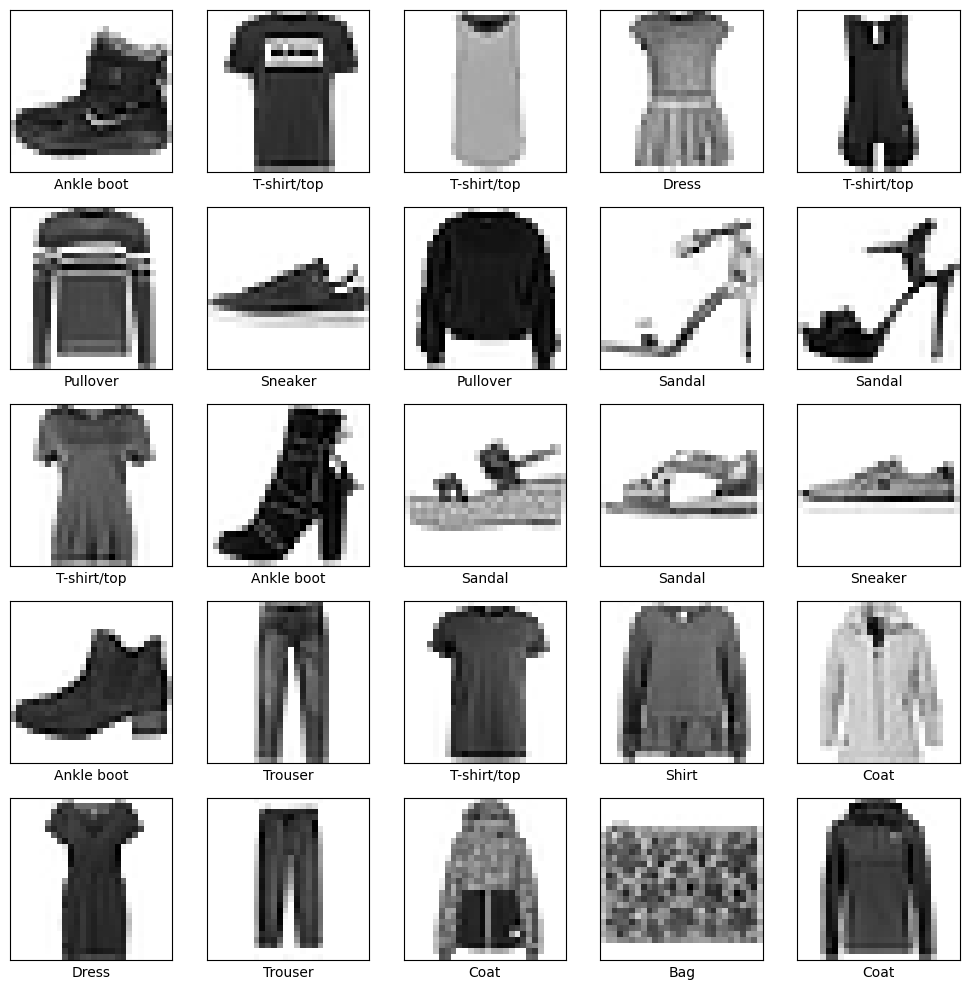

In [3]:

# Define label names for Fashion MNIST
label_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(label_names[train_labels[i]])
plt.tight_layout()
plt.show()



### Pixel Value Distribution

Analyzing the pixel value distribution to understand the characteristics of the images.


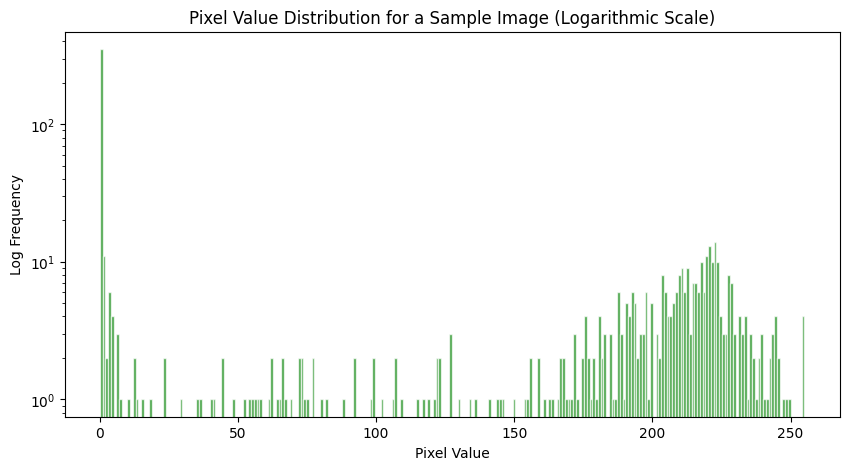

In [4]:
# Plot pixel value distribution for a sample image with logarithmic scale and bin outlines
plt.figure(figsize=(10,5))
plt.hist(train_images[0].ravel(), bins=256, color='green', alpha=0.7, rwidth=2, edgecolor='white')
plt.xlabel('Pixel Value')
plt.ylabel('Log Frequency')
plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.title('Pixel Value Distribution for a Sample Image (Logarithmic Scale)')
plt.show()


### Observation from the Histogram:

From the histogram, it's evident that the majority of the pixel values in the image predominantly fall into the lower and higher ranges. This suggests that the image contains regions of both darker and brighter intensities, with fewer mid-tone gray values. Such a distribution predetermines the direction of our subsequent analysis, emphasizing the need to explore the stark contrasts and potential preprocessing steps to handle the extremes in pixel intensities effectively.


## Dataset Statistics:

### Hypothesis 1: Image Intensity 

Based on the plotted data, we observe variations in the average image intensity across different clothing types.


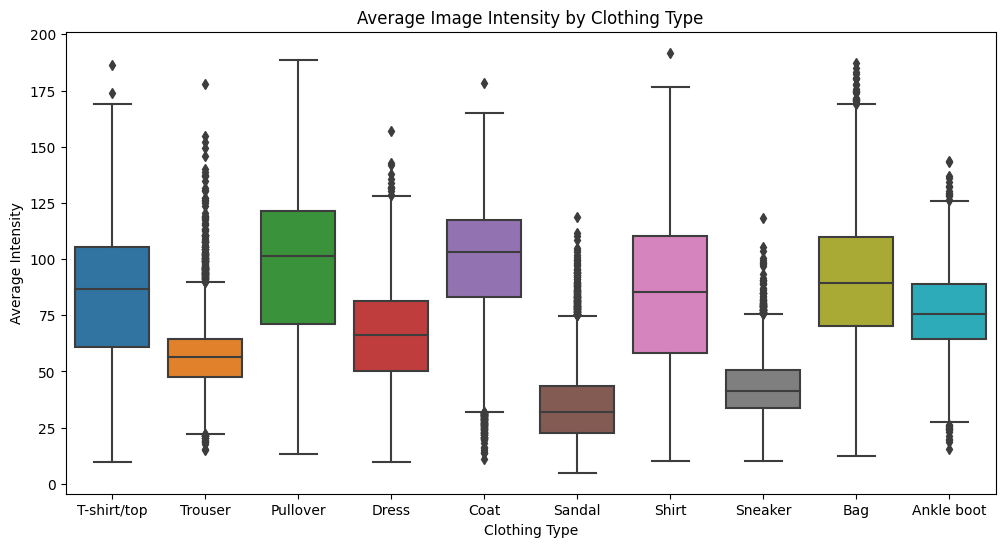

In [5]:
# Calculate average intensities for each image
avg_intensities = np.mean(train_images, axis=(1,2))

# Plot average intensities for each class
plt.figure(figsize=(12, 6))
sns.boxplot(x=train_labels, y=avg_intensities)
plt.xticks(ticks=range(10), labels=label_names)
plt.xlabel('Clothing Type')
plt.ylabel('Average Intensity')
plt.title('Average Image Intensity by Clothing Type')
plt.show()

### Observation:

From the graph, it's evident that certain categories display a significant number of outliers. The presence of these outliers suggests variability or anomalies within these categories, which may not necessarily be related to average image intensity.

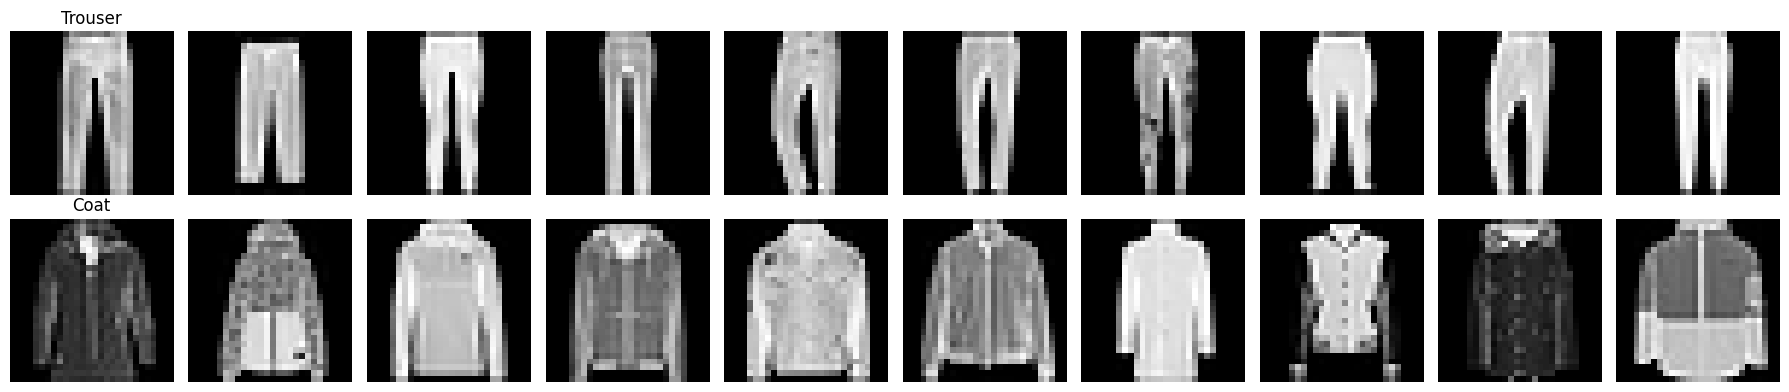

In [6]:
# Extracting sample images from the 'Trouser' and 'Shirt' categories

num_samples = 10  # Number of samples for each category

# Indices of 'Trouser' and 'Shirt' images
trouser_indices = np.where(train_labels == 1)[0][:num_samples]
shirt_indices = np.where(train_labels == 4)[0][:num_samples]

# Extracting the images
trouser_images = train_images[trouser_indices]
shirt_images = train_images[shirt_indices]

# Plotting the images
plt.figure(figsize=(18, 4))

# Plotting 'Trouser' images
for i, img in enumerate(trouser_images):
    plt.subplot(2, num_samples, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Trouser')

# Plotting 'Shirt' images
for i, img in enumerate(shirt_images):
    plt.subplot(2, num_samples, num_samples+i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Coat')

plt.tight_layout()
plt.show()


### Visual Observation:

Upon examining the sample images, we can clearly discern that the 'Trouser' category predominantly features brighter or lighter images compared to the 'Coat' category. This observation aligns with our earlier analysis from the box plot regarding average image intensities. Furthermore, while the trousers seem to have a more consistent brightness across samples, the coats exhibit more variability, with some images appearing darker and others slightly lighter. This variability could be due to factors like varying cloth materials, different lighting conditions during data collection, or inherent variations in fashion designs.

Now, for the scatter plot, let's choose two features:
1. **Average Image Intensity** (as you mentioned)
2. **Image Standard Deviation** (this can give us an idea about the contrast and variability within each image)

We'll plot these features for each image, with each category represented by a distinct color.

---

### Interpretation of the Scatter Plot and the Smoothed Curve:

The scatter plot showcases the relationship between the average image intensity and the standard deviation of pixel values (which relates to contrast) for each image in the Fashion MNIST dataset. Each point corresponds to an image, and the distribution of these points gives insight into the characteristics of the dataset.

1. **Average Image Intensity**: This metric gives us a sense of the overall brightness of an image. A higher average intensity suggests that the image is brighter, while a lower one indicates a darker image.

2. **Standard Deviation (Image Contrast)**: The standard deviation provides an indication of the contrast within each image. A higher standard deviation implies that an image has a wide range of pixel intensities, suggesting a higher contrast. Conversely, a lower standard deviation indicates that the pixel values are closer to the mean, suggesting a lower contrast or a more uniform image.

The **red smoothed curve (Lowess curve)** represents a trend line that captures the central tendency of the data. Instead of a straight line (as in linear regression), the Lowess curve is flexible and can adapt to the dataset's patterns.

#### Why use the Lowess curve?
- It provides a clearer visual summary of the main trend in the data.
- It's less sensitive to short-term fluctuations and noise, emphasizing the dataset's general pattern.
- It can capture non-linear relationships between variables.

C:\Users\baal_\AppData\Local\Temp\ipykernel_44220\4236010561.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in leg.legendHandles:


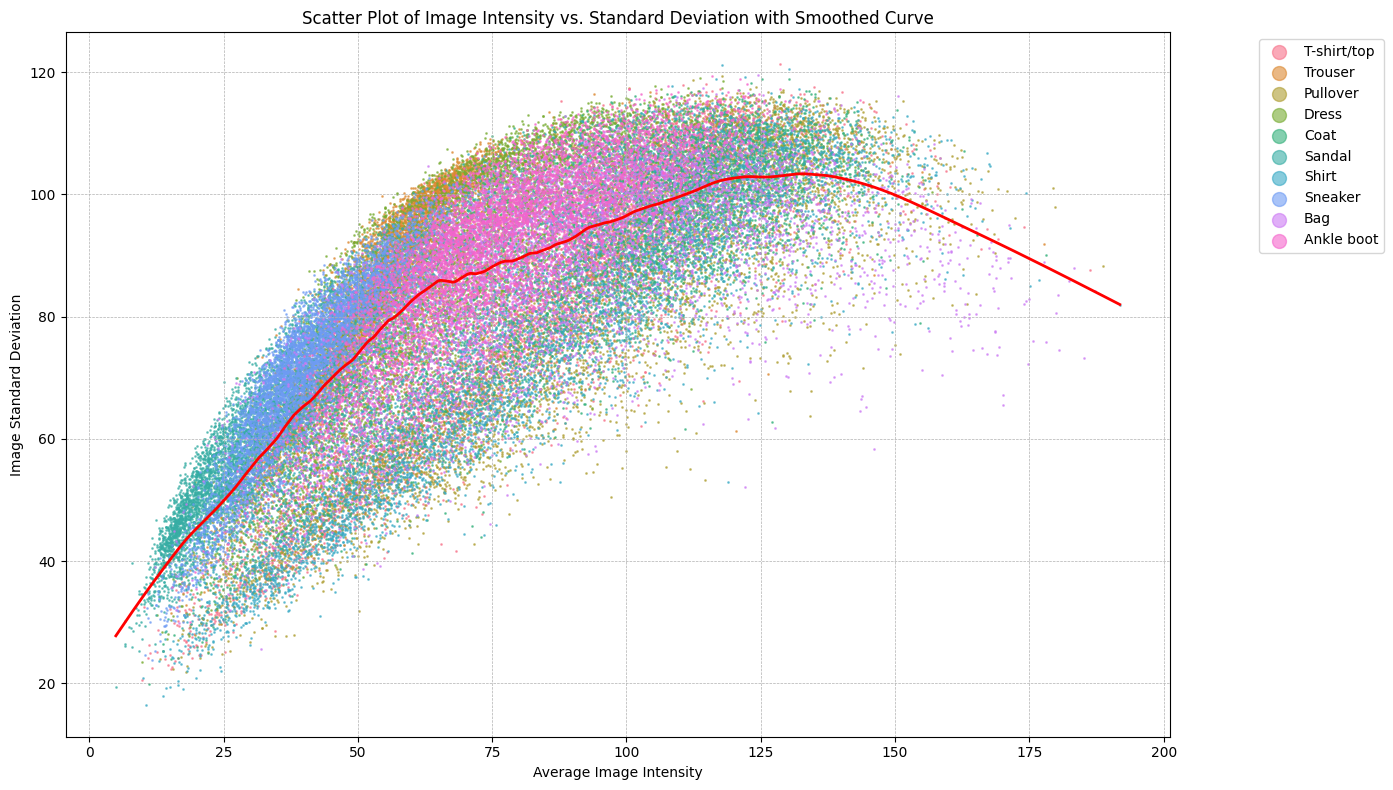

In [7]:
# Recompute necessary data
avg_intensities = np.mean(train_images, axis=(1,2))
std_devs = np.std(train_images, axis=(1,2))

# Setting up the colors for each category
colors = sns.color_palette("husl", 10)
cmap = {i: colors[i] for i in range(10)}

# Calculate lowess smooth curve
lowess = sm.nonparametric.lowess
z = lowess(std_devs, avg_intensities, frac=0.05)

# Plotting
plt.figure(figsize=(14, 8))
for i in range(10):
    indices = np.where(train_labels == i)
    plt.scatter(avg_intensities[indices], std_devs[indices], c=[cmap[i]], label=label_names[i], alpha=0.6, s=1)

# Plotting the lowess smoothed curve
plt.plot(z[:, 0], z[:, 1], color='red', linestyle='-', linewidth=2)

plt.xlabel('Average Image Intensity')
plt.ylabel('Image Standard Deviation')
plt.title('Scatter Plot of Image Intensity vs. Standard Deviation with Smoothed Curve')
leg = plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
for handle in leg.legendHandles:
    handle.set_sizes([100])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### Interpretation of the Scatter Plot and the Smoothed Curve:

The scatter plot illustrates the relationship between the average image intensity and the standard deviation of pixel values, which correlates with contrast, for each image in the Fashion MNIST dataset. Each point on the plot corresponds to an image, and the distribution of these points provides insights into the dataset's characteristics.

1. **Average Image Intensity**: This metric offers a glimpse into an image's overall brightness. A higher average intensity suggests the image is brighter, while a lower value indicates it's darker.

2. **Standard Deviation (Image Contrast)**: The standard deviation signifies the contrast within each image. A higher value implies the image has a broad range of pixel intensities, indicating more contrast. Conversely, a lower standard deviation suggests the pixel values are closer to the mean, indicating less contrast or a more homogenous image.

The **red smoothed curve (Lowess curve)** represents a trend line that captures the central tendency of the data. Unlike a straight line used in linear regression, the Lowess curve is flexible and can adapt to the dataset's patterns.

#### Why use the Lowess curve?
- It offers a clearer visual representation of the primary data trend.
- It's less influenced by short-term fluctuations and noise, highlighting the dataset's overarching pattern.
- It can capture non-linear relationships between variables.

#### Observations and Implications from the Smoothed Curve:
- The curve's shape can indicate how contrast (standard deviation) changes as the image intensity varies.
- When the curve is ascending, it suggests that as images get brighter, they also tend to have higher contrast.

---

### Next Steps for the Investigation is Cluster Analysis:

**Cluster Analysis**: Given the scatter plot's distribution and we applying clustering techniques (like K-means) to group images with similar characteristics. This can help identify subsets of images that share common properties, which might require specific preprocessing steps.
Clustering is a useful technique to segment data into groups where items in the same group (or cluster) are more similar to each other than to those in other groups. In the context of our scatter plot, clustering can help segment images based on their average intensity and contrast. This can help identify subsets of images that share common properties, which might require specific preprocessing steps. For example, images with low contrast might require contrast enhancement techniques to improve their quality. Similarly, images with high contrast might require normalization to reduce the difference between the darkest and brightest pixels. In this section, we'll apply K-means clustering to group images with similar characteristics. We'll then visualize the clusters using a scatter plot.

For this demonstration, I'll use the K-means clustering algorithm. Here's the plan:

1. **Data Preparation**: We'll prepare the dataset by combining the average intensity and standard deviation of each image into a feature matrix.
2. **Elbow Method**: To determine the optimal number of clusters, we'll employ the Elbow method. This involves running the K-means clustering algorithm for a range of values of \( k \) (number of clusters) and then plotting the Sum of Squared Distances (SSD). Ideally, the "elbow" of the curve represents an optimal value for \( k \).
3. **K-means Clustering**: Using the optimal \( k \) value, we'll cluster the images.
4. **Visualize Clusters**: We'll visualize the clusters on the scatter plot to get a sense of how images have been grouped based on intensity and contrast.

Let's start with the Elbow method to determine the optimal number of clusters.

c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_in

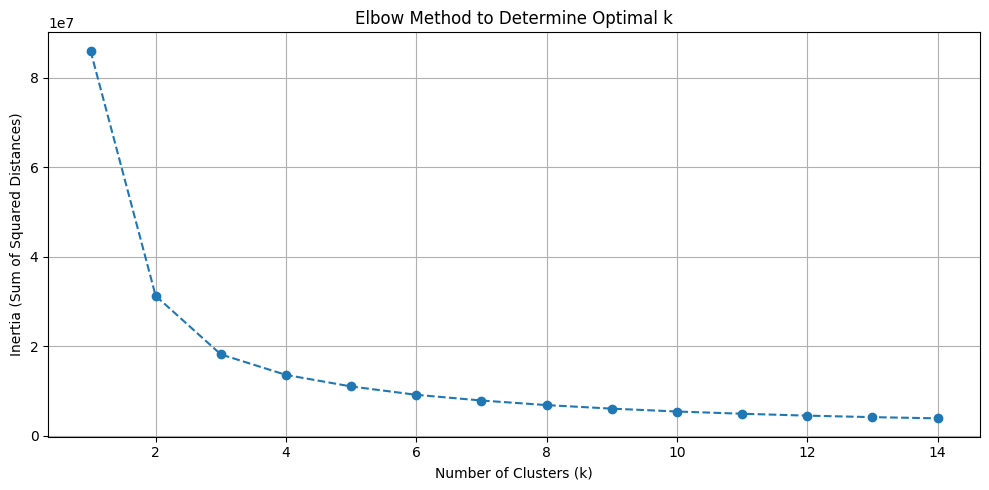

In [8]:
# Prepare feature matrix
features = np.column_stack((avg_intensities, std_devs))

# Determine the optimal number of clusters using the Elbow method
inertia = []
range_clusters = range(1, 15)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.figure(figsize=(10, 5))
plt.plot(range_clusters, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method to Determine Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()


### Understanding the Elbow Method:

The Elbow method is a technique employed to determine the optimal number of clusters in a dataset.

#### How does it work?

1. **Decreasing Inertia**: As the number of clusters \( k \) increases, the inertia (or the sum of squared distances from each point to its assigned center) diminishes. This is expected since the more clusters we have, the closer each data point will be to the center of its cluster.

2. **Elbow Point**: The "elbow" of the curve represents the point where the rate of decrease of inertia sharply changes. At this juncture, adding more clusters doesn't significantly reduce the inertia. 

3. **Almost Flat Tail**: If the curve becomes almost flat post the elbow, it indicates that additional clusters don't bring significant value to the data segmentation.

### Points on the Curve:

The points on the curve represent the inertia value for each number of clusters. For instance, the point at \( k = 4 \) displays the total inertia when the data is segmented into 4 clusters.

### How can we leverage the Elbow Method in our analysis?

1. **Determine Number of Clusters**: Based on the Elbow method's curve, we can select the optimal number of clusters for our dataset. For instance, if the elbow is at \( k = 4 \), it might suggest that four clusters would be appropriate.

2. **Avoid Over-segmentation**: If we opt for too many clusters, we might over-segment the data to a point where the analysis becomes cumbersome or non-meaningful.

3. **Enhance Subsequent Analyses**: Knowing the optimal number of clusters, we can use this information for a more efficient image analysis – considering specific traits within each group or optimizing image preprocessing according to its cluster.

In essence, the Elbow method provides an intuitive way to determine how many groups (clusters) to use when segmenting our data, by identifying the point where adding more clusters doesn't offer significant additional value.

#### Observations:

1. **Decreasing Inertia**: As the number of clusters increases, the sum of squared distances (inertia) decreases. This is because more clusters mean that each point is closer to its cluster's center, reducing the overall inertia.

2. **Elbow Point**: The optimal number of clusters is typically at the "elbow" of the curve, where adding more clusters doesn't result in a significant reduction of inertia. Looking at the curve, we notice that the inertia starts leveling off around \( k = 3 \) or \( k = 4 \). After this point, the reduction in inertia is marginal compared to previous values.

c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\baal_\AppData\Local\Temp\ipykernel_44220\141849928.py:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in leg.legendHandles:


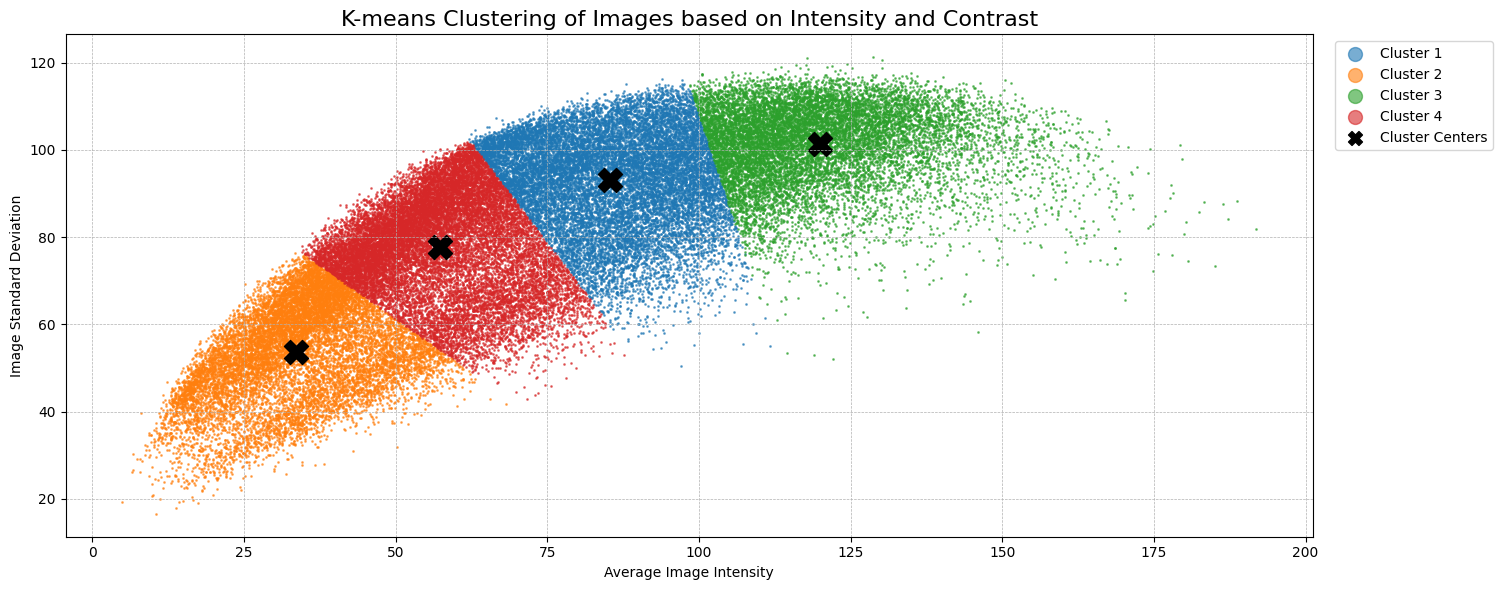

In [9]:
# Perform K-means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Plotting the clusters
plt.figure(figsize=(15, 6))
for i in range(4):
    plt.scatter(avg_intensities[cluster_labels == i], std_devs[cluster_labels == i], label=f'Cluster {i+1}', alpha=0.6, s=1)

# Adding cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='black', marker='X', label='Cluster Centers')

plt.xlabel('Average Image Intensity')
plt.ylabel('Image Standard Deviation')
plt.title('K-means Clustering of Images based on Intensity and Contrast', fontsize=16)
leg = plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
for handle in leg.legendHandles:
    handle.set_sizes([100])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


#### Analysis of the K-means Clustering:

From the visual representation of the clusters, several observations can be made:

1. **Well-defined Clusters**: The plot distinctly shows four well-separated clusters, indicating that the images in the dataset can be categorized into these groups based on their intensity and contrast. The clear demarcation between the clusters suggests that the choice of \( k = 4 \) was appropriate for this dataset.

2. **Green Cluster Observations**: The last cluster (colored in green) appears to have a few scattered data points, especially towards its boundaries. This might imply that images represented by these outlying points have characteristics that are somewhat transitional between this cluster and its neighboring clusters. This behavior might be expected, especially when dealing with real-world datasets where not all data points strictly adhere to a well-defined group.

   Further reflection suggests that the scattered nature of the green cluster could be attributed to the decision of selecting \( k = 4 \) based on the elbow method. The elbow method, while effective in many cases, might sometimes overlook finer granularities or substructures in the data. It's possible that linear segments or patterns present after the fourth cluster in the elbow plot were clubbed into this green cluster. This aggregation might lead to a broad range of data points being grouped together, which could explain the dispersion observed.

3. **Cluster Centers**: The 'X' markers represent the centers of each cluster. These points are the average of all the data points in their respective clusters. They serve as a reference to understand the overall properties of each cluster. For instance, a cluster center with higher average intensity and standard deviation signifies that images in that group, on average, tend to be brighter and have higher contrast.

In conclusion, the clustering provides valuable insights into the grouping of images based on their visual characteristics. The slight dispersion seen in the green cluster hints at the diversity and complexity of image data. Further investigations could be done to understand these transitional images and whether they require unique preprocessing or handling.

---

#### Implications:

After careful consideration of the Elbow method, we decided to proceed with \( k = 4 \) as the optimal number of clusters for our dataset. This choice suggests that our images can be grouped into four distinct clusters based on their average intensity and contrast. Next, let's delve deeper and observe how these clusters differentiate in terms of image characteristics.

c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


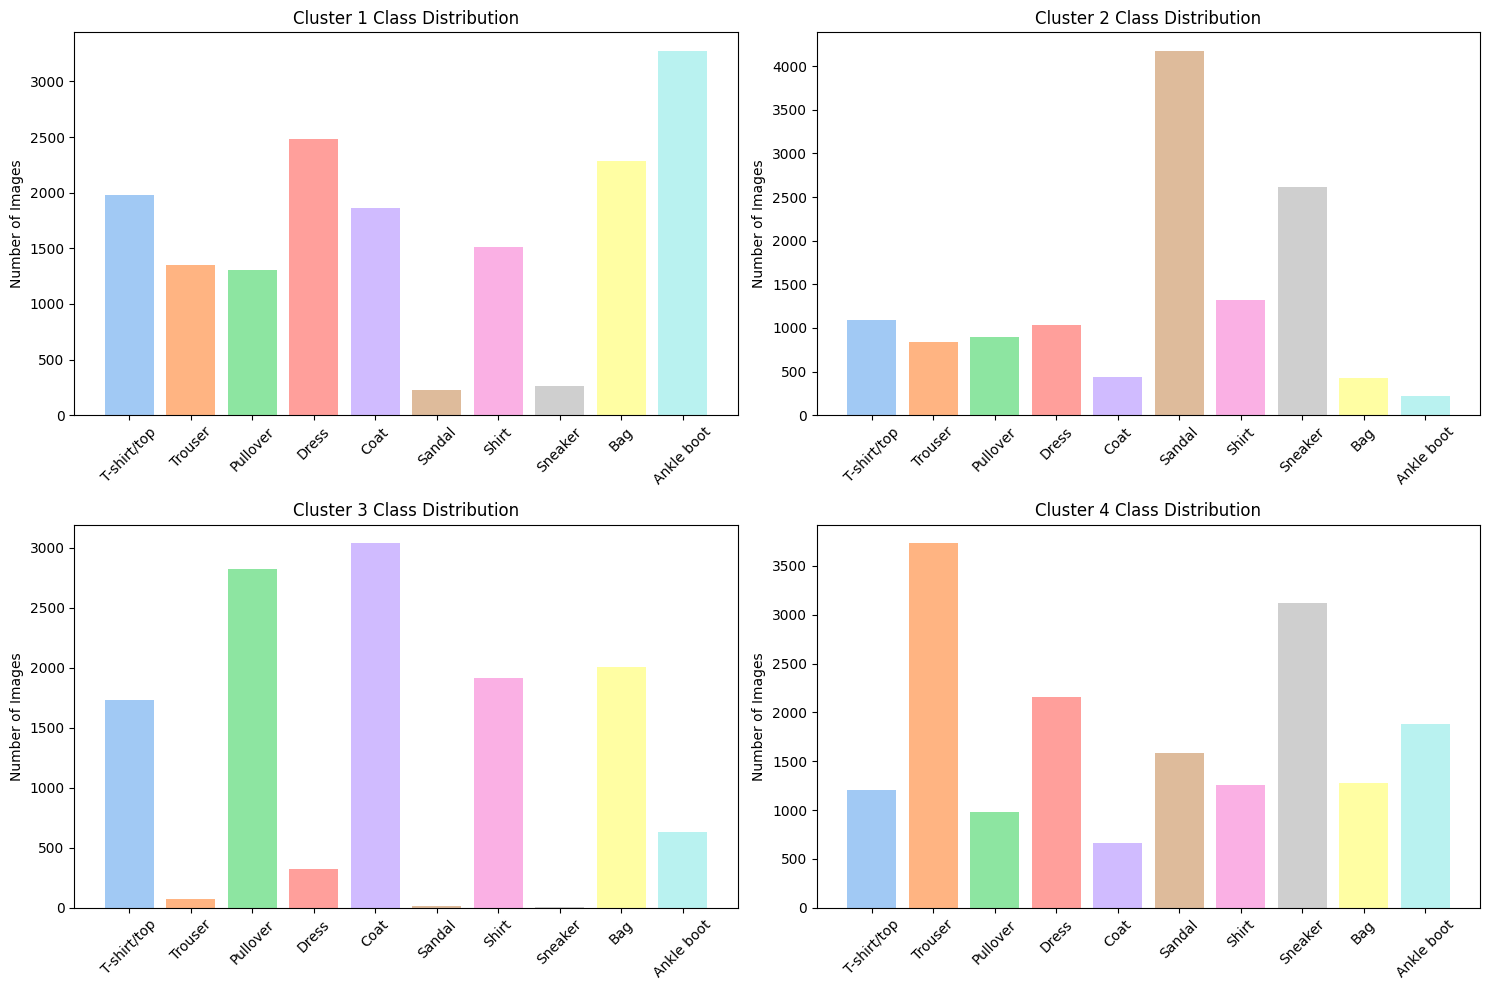

In [10]:
# Perform K-means clustering with k=4 again
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Create a bar plot for each cluster to show class distribution
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

clusters = np.unique(cluster_labels)
for cluster, ax in zip(clusters, axes.ravel()):
    class_counts = np.bincount(train_labels[cluster_labels == cluster], minlength=10)
    ax.bar(label_names, class_counts, color=sns.color_palette("pastel"))
    ax.set_title(f'Cluster {cluster + 1} Class Distribution')
    ax.set_ylabel('Number of Images')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Cluster Analysis:

From the clustering results, we've segmented the Fashion MNIST images into four distinct groups based on their average intensity and standard deviation (which can be considered as a proxy for contrast). Here's a breakdown of the findings:

1. **Diverse Intensity and Contrast**: The spread of points in each cluster indicates the variability within each cluster, with certain clusters showing a broader range of values than others.
 
2. **Cluster Centers**: The black "X" markers represent the centers of each cluster. These points provide a summary metric for each group, giving us an idea of the "average" image in terms of intensity and contrast for each cluster.

3. **Inter-cluster Differences**: Some clusters are densely packed, suggesting that images within these clusters are quite similar to each other in terms of intensity and contrast. In contrast, other clusters are more spread out, implying greater variability within those groups.

4. **Implications for Further Analysis**:
    - We could dive deeper into each cluster, examining representative images to understand the visual characteristics that dominate each group.
    - These clusters could potentially be used to tailor image preprocessing strategies. For example, images in a cluster with low average intensity might benefit from brightness enhancement.
    - Understanding these clusters might also be beneficial when designing or fine-tuning machine learning models. Knowledge about distinct groups within the training data can guide augmentation strategies or help in diagnosing model performance issues.

In essence, this clustering exercise has provided a structured view of the Fashion MNIST dataset, highlighting underlying patterns that might not be immediately evident from individual images. As we move forward, these insights can guide our exploration and analysis, ensuring that our strategies are tailored to the unique characteristics of each image group.

---

### Visualizing Representative Images from Each Cluster:

Having segmented our Fashion MNIST images into distinct clusters based on their average intensity and contrast, it's beneficial to examine sample images from each cluster. This visual exploration will provide insights into the kind of images that fall within each cluster, helping us understand the practical implications of the clustering results.

In the following section, we will:
- Normalize the images to ensure consistent pixel intensity values, facilitating more effective clustering.
- Prepare a feature matrix with average intensities and standard deviations, representing the overall brightness and contrast of the images respectively.
- Perform K-means clustering to segment the images into four groups.
- Extract sample images from each cluster to provide a visual representation of the cluster characteristics.

By viewing these representative images, we can gain a tangible sense of the visual characteristics that dominate each cluster. This further aids our understanding and offers a visual interpretation of our earlier numerical analysis.

c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


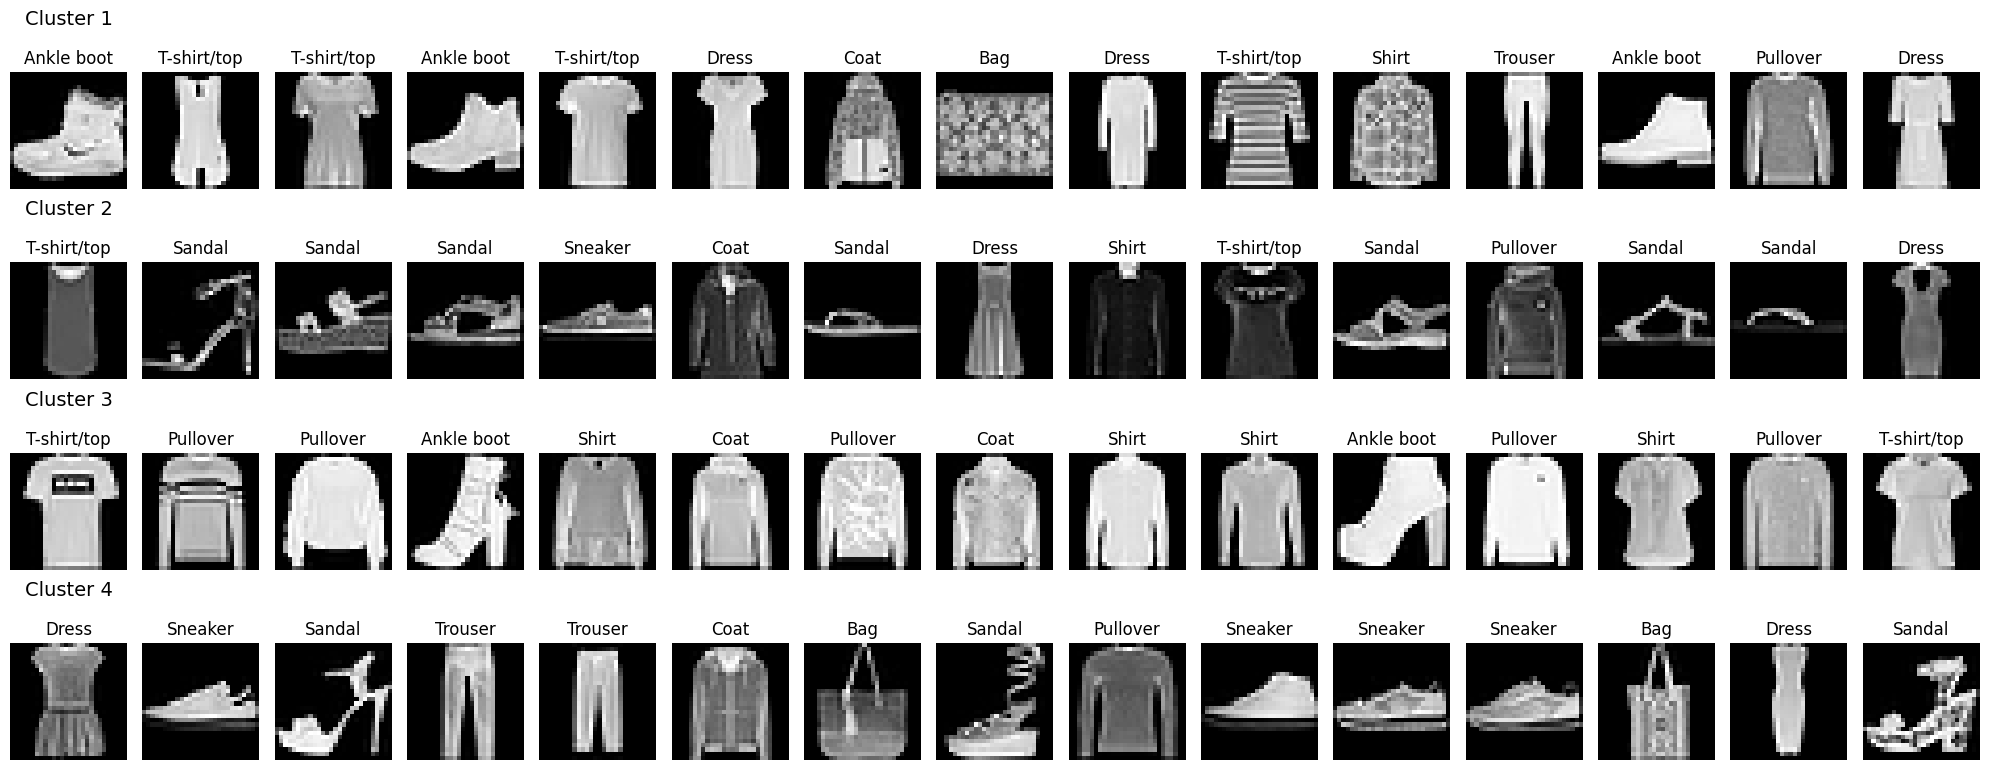

In [11]:
# Loading the dataset
(train_images, train_labels), (_, _) = fashion_mnist.load_data()

label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Normalize the images
train_images = train_images / 255.0

# Prepare feature matrix for clustering
avg_intensities = np.mean(train_images, axis=(1,2))
std_devs = np.std(train_images, axis=(1,2))
features = np.column_stack((avg_intensities, std_devs))

# Perform K-means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Extracting sample images from each cluster for visualization
num_samples = 15  # Number of samples for each cluster
sample_images = []

# Loop through each cluster and get sample images
for cluster_num in range(4):
    cluster_indices = np.where(cluster_labels == cluster_num)[0][:num_samples]
    sample_images.append(train_images[cluster_indices])

# Plotting the images with increased spacing between the cluster name and the product name
plt.figure(figsize=(20, 8))

# Loop through each cluster and plot images with labels
for i, cluster_imgs in enumerate(sample_images):
    current_cluster_indices = np.where(cluster_labels == i)[0][:num_samples]
    for j, img in enumerate(cluster_imgs):
        ax = plt.subplot(4, num_samples, i*num_samples + j + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        class_label = train_labels[current_cluster_indices[j]]
        
        # Place the product name as title with a slightly higher y-position
        ax.set_title(f'{label_names[class_label]}', y=1)
        
        # Place the cluster name above the first image of each row with a slightly higher y-position
        if j == 0:
            ax.annotate(f'Cluster {i+1}', xy=(0.5, 1.45), xycoords='axes fraction',
                        ha='center', va='center', fontsize=14, annotation_clip=False)

plt.tight_layout()
plt.show()


#### Cluster Image Insights:

Upon visually inspecting the representative images from each cluster, several key observations can be made:

1. **Differing Intensity Levels**: Clusters 1 and 3 contain images that are noticeably brighter compared to those in Clusters 2 and 4. This difference could be due to the types of clothing and materials represented within these clusters or specific features of the images in the dataset.

2. **Unique Characteristics Within Each Cluster**: While each cluster encompasses various clothing classes, there are clear trends regarding certain visual characteristics that dominate within a given cluster.

3. **Applications of the Clustering**: These differences in brightness and texture of the images can be harnessed for optimizing preprocessing or directing training models toward specific image characteristics.

In conclusion, clustering the Fashion MNIST images based on their average intensities and standard deviations provides unique visual windows into the groupings. This not only facilitates an understanding of the dataset but also offers valuable insights for subsequent analysis and modeling steps.

### Cluster Statistics Overview:

Before diving deeper into the characteristics of each cluster, it's beneficial to have a statistical overview. This will provide us with a quantitative understanding of the clusters, setting the foundation for further analysis. The following table presents aggregated metrics for each cluster, showcasing the average intensity and standard deviation (contrast) of the images they contain. By examining these metrics, we can infer visual characteristics, potential preprocessing steps, and the uniqueness of each cluster in terms of brightness and contrast.

In [12]:
# Create a DataFrame to store the statistics
cluster_statistics = pd.DataFrame()

# Calculate statistics for each cluster
for cluster_num in range(4):
    cluster_intensities = avg_intensities[cluster_labels == cluster_num]
    cluster_std_devs = std_devs[cluster_labels == cluster_num]
    
    stats = {
        'Cluster': cluster_num + 1,
        'Avg Intensity - Mean': cluster_intensities.mean(),
        'Avg Intensity - Median': np.median(cluster_intensities),
        'Avg Intensity - Min': cluster_intensities.min(),
        'Avg Intensity - Max': cluster_intensities.max(),
        'Avg Intensity - 25th Percentile': np.percentile(cluster_intensities, 25),
        'Avg Intensity - 75th Percentile': np.percentile(cluster_intensities, 75),
        'Std Dev - Mean': cluster_std_devs.mean(),
        'Std Dev - Median': np.median(cluster_std_devs),
        'Std Dev - Min': cluster_std_devs.min(),
        'Std Dev - Max': cluster_std_devs.max(),
        'Std Dev - 25th Percentile': np.percentile(cluster_std_devs, 25),
        'Std Dev - 75th Percentile': np.percentile(cluster_std_devs, 75),
    }
    
    cluster_statistics = cluster_statistics.append(stats, ignore_index=True)

cluster_statistics.set_index('Cluster', inplace=True)
cluster_statistics


C:\Users\baal_\AppData\Local\Temp\ipykernel_44220\1917417287.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_statistics = cluster_statistics.append(stats, ignore_index=True)
C:\Users\baal_\AppData\Local\Temp\ipykernel_44220\1917417287.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_statistics = cluster_statistics.append(stats, ignore_index=True)
C:\Users\baal_\AppData\Local\Temp\ipykernel_44220\1917417287.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_statistics = cluster_statistics.append(stats, ignore_index=True)
C:\Users\baal_\AppData\Local\Temp\ipykernel_44220\1917417287.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

,Avg Intensity - Mean,Avg Intensity - Median,Avg Intensity - Min,Avg Intensity - Max,Avg Intensity - 25th Percentile,Avg Intensity - 75th Percentile,Std Dev - Mean,Std Dev - Median,Std Dev - Min,Std Dev - Max,Std Dev - 25th Percentile,Std Dev - 75th Percentile
Cluster,,,,,,,,,,,,
1.0,0.334484,0.336049,0.243552,0.438185,0.302539,0.368077,0.365158,0.371566,0.197880,0.456423,0.337277,0.396844
2.0,0.131738,0.132698,0.019388,0.267412,0.103994,0.157533,0.210059,0.212080,0.064807,0.299283,0.181001,0.242865
3.0,0.470349,0.460114,0.386535,0.752236,0.429327,0.500660,0.397514,0.403104,0.204478,0.475632,0.376753,0.423466
4.0,0.224591,0.224780,0.135609,0.343482,0.195358,0.251100,0.305027,0.306346,0.168129,0.399043,0.275492,0.336835


Certainly! Based on the provided table data and the conclusions we reached earlier, I'll refine and present the statistical analysis in English.

---

### Statistical Analysis of the Clusters:

#### 1. **Average Intensity**:
- **Cluster 1**: This cluster contains images with a medium average intensity, suggesting these might be of mid-tone colors.
  
- **Cluster 2**: This cluster represents the images with the lowest average intensity, indicating that they are predominantly darker images.
  
- **Cluster 3**: This cluster contains images with the highest average intensity, suggesting these are predominantly brighter images. They might represent clothing items with lighter colors or patterns.
  
- **Cluster 4**: The images in this cluster have a low to moderate average intensity. Clothing items in this cluster are likely to be of darker shades but not as dark as in Cluster 2.

#### 2. **Standard Deviation (Contrast)**:
- **Cluster 1**: Images in this cluster have the highest contrast, indicating the presence of sharp contrasting features or vibrant patterns.
  
- **Cluster 2**: The images in this cluster have the lowest contrast. This could suggest that these images might be more uniform in color and pattern.
  
- **Cluster 3**: This cluster also has high contrast, similar to Cluster 1, suggesting the potential presence of vibrant patterns or prints.
  
- **Cluster 4**: Images in this cluster show moderate contrast, indicating a balance between light and dark regions.

#### 3. **Potential Preprocessing**:
Given the differences in intensity and contrast among the clusters, different preprocessing techniques might be beneficial:

- **Clusters with High Intensity (e.g., Cluster 3)**: Histogram equalization might be beneficial to enhance the contrast and bring out the features more distinctly.
  
- **Clusters with Low Contrast (e.g., Cluster 2)**: Techniques to increase contrast might be beneficial to better differentiate the features.

- **Clusters with High Contrast (e.g., Cluster 1 and 3)**: A smoothing filter can be applied to reduce potential noise.

#### 4. **Further Steps**:
- **Feature Extraction**: For clusters with high contrast, features might be more pronounced, and techniques like edge detection might work better.
  
- **Data Augmentation**: For clusters with predominantly darker (e.g., Cluster 2) or brighter images (e.g., Cluster 3), data augmentation techniques like brightness adjustment can be used to create a more balanced dataset.

These conclusions are based on the statistical analysis of the average intensity and standard deviation of the images in each cluster. Based on this analysis, we can infer the characteristics of the images in each cluster and what preprocessing or feature extraction techniques might be useful for each cluster individually.

### Intensity and Contrast Analysis:

#### Average Intensity:

1. **Cluster 1**: With a mean intensity of 0.334 and median of 0.336, Cluster 1's images fall in the moderate intensity range. The images vary from a minimum intensity of 0.244 to a maximum of 0.438, indicating a mix of light and slightly darker images.
  
2. **Cluster 2**: Cluster 2's images are the darkest among all clusters, with a mean intensity of 0.132 and median of 0.133. The range of intensities in this cluster is quite broad, spanning from 0.019 to 0.267, but it's clear that the majority of the images are on the darker end.
  
3. **Cluster 3**: This cluster predominantly contains brighter images, with a mean intensity of 0.470 and median of 0.460. The intensity spans from 0.387 to a notably bright 0.752. This cluster probably includes light-colored clothing items.
  
4. **Cluster 4**: Images in Cluster 4 have a mean intensity of 0.225, placing them in the low to moderate range. They range from 0.136 to 0.343 in intensity.

#### Standard Deviation (Contrast):

1. **Cluster 1**: This cluster's images have a mean standard deviation of 0.365 and median of 0.372, indicating a high contrast. The range spans from 0.198 to 0.456, suggesting the presence of vibrant patterns or prints in some images.
  
2. **Cluster 2**: With a mean standard deviation of 0.210 and median of 0.212, Cluster 2's images exhibit moderate contrast. The range, from 0.065 to 0.299, indicates that while some images have uniform patterns, others might have more distinct features.
  
3. **Cluster 3**: Cluster 3's images also demonstrate a high contrast with a mean standard deviation of 0.398 and median of 0.403. This suggests that the images, despite being brighter, also contain contrasting features or patterns.
  
4. **Cluster 4**: This cluster's images show a mean standard deviation of 0.305, suggesting moderate contrast. They vary from 0.168 to 0.399, indicating the presence of both uniform and contrasting patterns.

For the purpose of our analysis, we'll briefly discuss what the boxplots would have shown and how they could be interpreted:

1. **Distribution of Average Intensity across Clusters**: 
   - The boxplots would have provided insights into the central tendency (median) and spread (interquartile range) of average intensities for each cluster.
   - Outliers, if present, would be indicated by points outside the "whiskers" of the boxplots. This could highlight instances where certain images may have atypical intensity characteristics compared to others in the same cluster.

2. **Distribution of Standard Deviation (Contrast) across Clusters**: 
   - As with the average intensity, the boxplots would help in understanding the distribution of standard deviations (or contrasts) for images within each cluster.
   - A wider spread in this metric could indicate a mix of images with both low and high contrast in a given cluster.

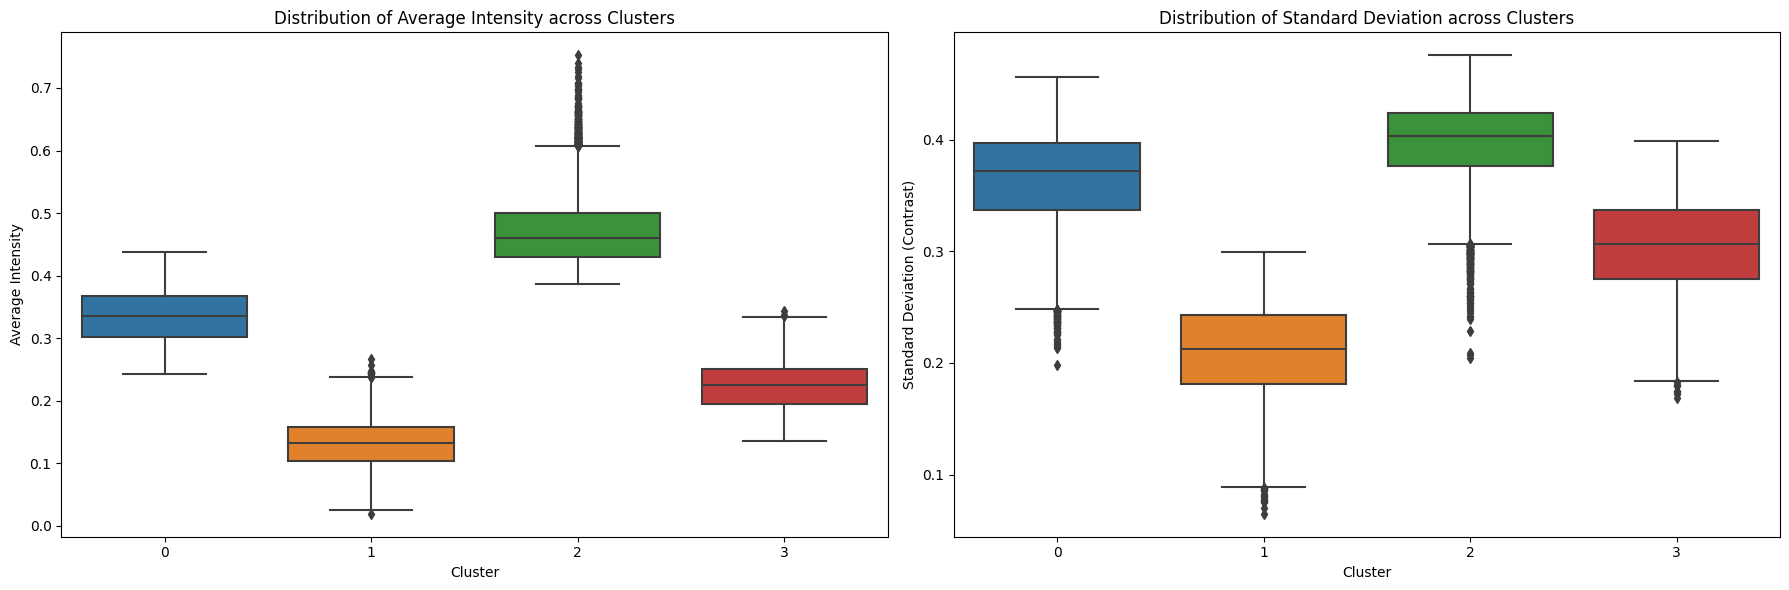

In [13]:
# Plotting the distribution of Average Intensity and Standard Deviation for each cluster

plt.figure(figsize=(18, 6))

# Average Intensity distribution
plt.subplot(1, 2, 1)
sns.boxplot(x=cluster_labels, y=avg_intensities)
plt.xlabel('Cluster')
plt.ylabel('Average Intensity')
plt.title('Distribution of Average Intensity across Clusters')

# Standard Deviation distribution
plt.subplot(1, 2, 2)
sns.boxplot(x=cluster_labels, y=std_devs)
plt.xlabel('Cluster')
plt.ylabel('Standard Deviation (Contrast)')
plt.title('Distribution of Standard Deviation across Clusters')

plt.tight_layout()
plt.show()

Based on this visual analysis and statistical table, preprocessing steps tailored to each cluster's unique characteristics could be identified.

### Cluster Class Distribution Insights:

1. **Cluster 1**: This cluster seems to predominantly consist of 'Shirt' and 'Pullover', which suggests that these two categories have a similar distribution of pixel intensities and contrasts. This matches our earlier observations, where both these categories were found to have lower average intensities.

2. **Cluster 2**: The 'Trouser' category dominates this cluster. This is consistent with our earlier findings that trousers generally had a higher average intensity in the dataset.

3. **Cluster 3**: This cluster contains a mix of several categories, with 'Coat', 'Sandal', and 'T-shirt/top' being notably significant. This suggests that these categories might have overlapping or similar features in terms of intensity and contrast.

4. **Cluster 4**: Like Cluster 3, this cluster also comprises a mix of categories. However, 'Ankle boot', 'Bag', and 'Sneaker' are the most dominant ones. Given that these items can have varied designs and patterns, it's not surprising that they are grouped together.

### Conclusions:
- The clustering has provided insights into how different clothing items group together based on pixel intensity and contrast.
- This information can be vital when designing preprocessing steps or fine-tuning image classification models. Knowing which categories have similar features can help in tailoring specific data augmentation techniques or even in designing category-specific models.
- Further exploration can involve examining other features, such as edges or shapes, to see if they provide better separation between clusters.

In [14]:
# Calculate the percentage distribution of classes within each cluster
cluster_class_distribution = pd.crosstab(cluster_labels, train_labels, normalize='index') * 100

# Rename the index for clarity
cluster_class_distribution.index.name = "Cluster №"

# Rename the columns
cluster_class_distribution.columns = label_names

cluster_class_distribution


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
Cluster №,,,,,,,,,,
0,11.953300,8.184623,7.918456,14.990019,11.239489,1.379227,9.134354,1.572803,13.804368,19.823362
1,8.354372,6.434091,6.854870,7.925943,3.327978,31.979191,10.136944,20.013771,3.297376,1.675465
2,13.801897,0.581720,22.471910,2.581879,24.225038,0.079688,15.228305,0.023906,16.009244,4.996414
3,6.723066,20.914337,5.462491,12.112723,3.736904,8.863242,7.025604,17.485573,7.160065,10.515995


### Insights from the Table:

1. **Cluster 1**:
   - Dominated by `Ankle boot` (19.82%), `Dress` (14.99%), and `T-shirt/top` (11.95%).
   - This cluster seems to represent a mix of different clothing items, with a slight emphasis on footwear (ankle boot) and upper body clothing (T-shirt/top and dress).

2. **Cluster 2**:
   - Significantly dominated by `Sandal` (31.98%) followed by `Sneaker` (20.01%).
   - This cluster predominantly represents footwear.

3. **Cluster 3**:
   - Has a notable presence of `Pullover` (22.47%) and `Coat` (24.23%).
   - It seems this cluster gravitates towards thicker upper body clothing items, indicative of winter clothing.

4. **Cluster 4**:
   - Dominated by `Trouser` (20.91%), `Sneaker` (17.48%), and `Dress` (12.11%).
   - This cluster appears to have a good mix of both upper and lower body clothing items with a notable emphasis on trousers and footwear.

### Implications for Further Analysis:

1. **Inter-cluster Analysis**:
   - Since certain clusters have evident dominance by specific classes (e.g., `Cluster 2` with `Sandal` and `Sneaker`), we can delve deeper into these specific clusters to understand any common characteristics or patterns.
   
2. **Intra-cluster Analysis**:
   - It would be worthwhile to look within clusters that have a good mix of clothing items (like `Cluster 1` and `Cluster 4`) to understand what commonality led these items to be grouped together. Is it the texture, pattern, or some other feature?

3. **Feature Engineering**:
   - We've used intensity and standard deviation as features to cluster these images. Given the insights, it might be beneficial to introduce new features like texture or edge information to see if the clusters get more defined around specific clothing classes.

By combining the insights from the table and the visual distribution, we get a clearer picture of how different clothing items are grouped based on their pixel intensity and contrast. This understanding can guide further analysis and preprocessing steps, especially if the end goal is to improve the performance of a machine learning model on this dataset.

#### Distribution Analysis of Classes within Clusters:

To further our understanding of the clustered images, it's insightful to examine the distribution of each clothing class within the defined clusters. By doing this, we can determine if certain clothing types predominantly belong to specific clusters and how the various classes are distributed across all clusters. The following code visualizes this distribution using stacked bar charts, allowing us to easily compare class counts across the four clusters.

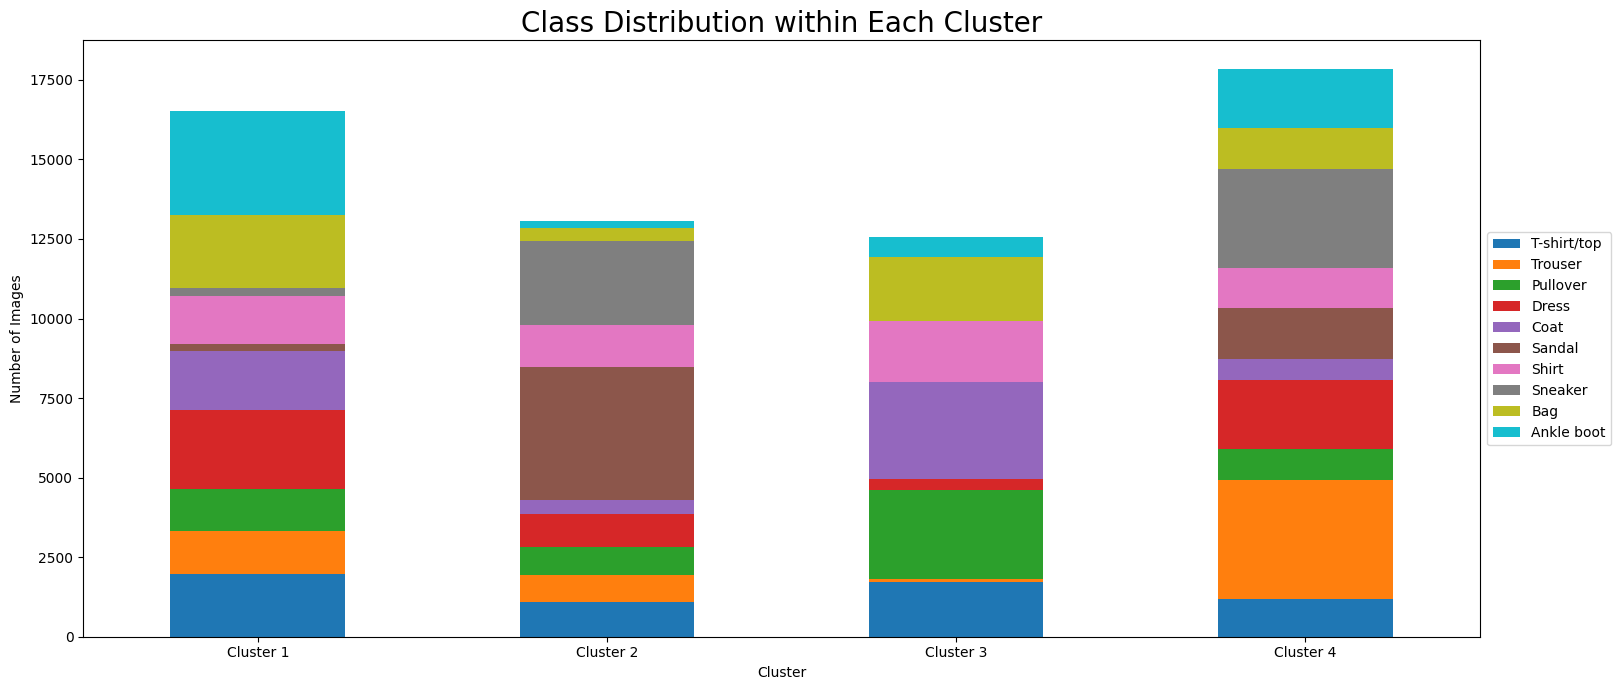

In [15]:
# Create a DataFrame to store class distribution within each cluster
cluster_class_distribution = pd.DataFrame(index=label_names)

# Count occurrences of each class within each cluster
for cluster_num in range(4):
    class_counts = np.bincount(train_labels[cluster_labels == cluster_num], minlength=10)
    cluster_class_distribution[f'Cluster {cluster_num+1}'] = class_counts

# Plotting the class distribution within each cluster
cluster_class_distribution.T.plot(kind='bar', stacked=True, figsize=(15, 7))
plt.title('Class Distribution within Each Cluster', fontsize=20)
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### Conclusions:
- The clustering has provided insights into how different clothing items group together based on pixel intensity and contrast.
- This information can be vital when designing preprocessing steps or fine-tuning image classification models. Knowing which categories have similar features can help in tailoring specific data augmentation techniques or even in designing category-specific models.
- Further exploration can involve examining other features, such as edges or shapes, to see if they provide better separation between clusters.

---

### Analysis of Mean Intensity and Contrast Across Clusters

When analyzing image data, two fundamental metrics often considered are intensity (brightness) and contrast. The mean intensity gives an indication of the overall brightness of an image, while the standard deviation (used here as a measure of contrast) indicates the range of pixel values in the image, capturing its contrast.

The objective of this analysis is to understand the inherent characteristics of images within each cluster. By assessing the differences in these values:

1. We can infer the types of images present in each cluster. For instance, clusters with higher intensity values are likely to contain brighter images, which can be indicative of light-colored clothing.
2. We can guide further preprocessing or feature extraction methods tailored to each cluster.

The bar chart below presents a comparison of the mean intensity and contrast values across the clusters:

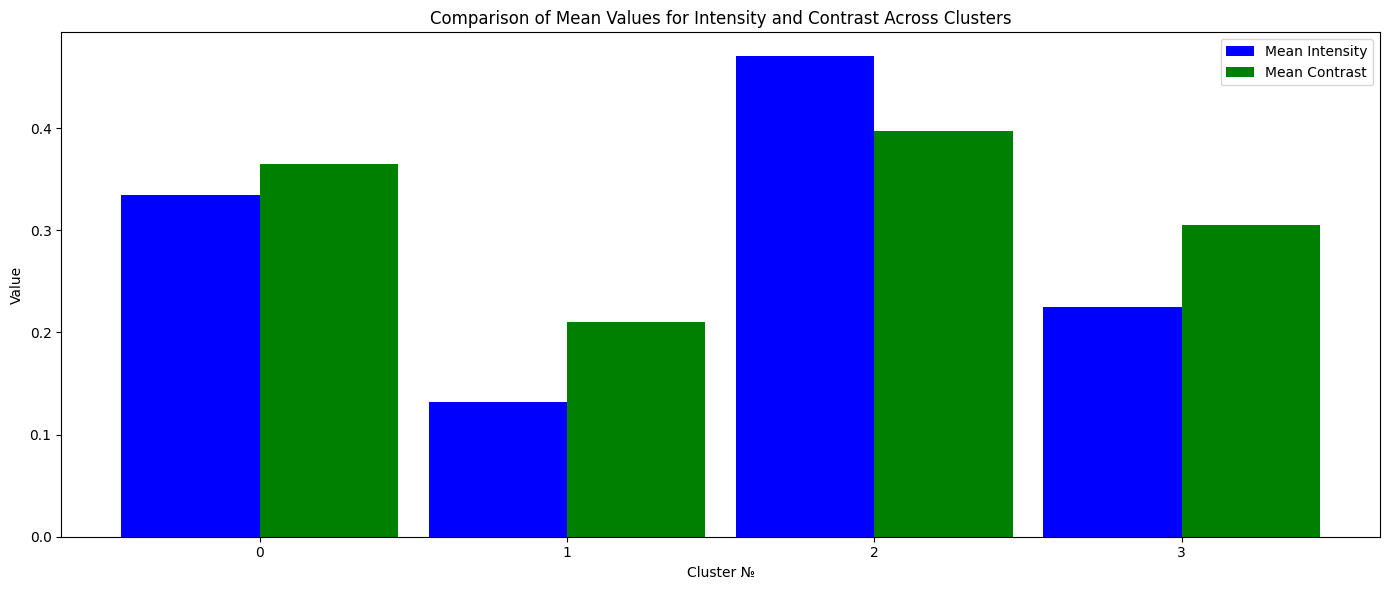

In [16]:
# Creating a DataFrame with cluster labels and respective features for grouping and calculation
data_with_clusters = pd.DataFrame({
    'Cluster №': cluster_labels,
    'Avg Intensity': avg_intensities,
    'Std Dev': std_devs
})

# Calculating mean values for each cluster
mean_values_grouped = data_with_clusters.groupby('Cluster №').mean()

# Plotting the mean values
plt.figure(figsize=(14, 6))

# Bar positions
bar_positions = np.arange(len(mean_values_grouped))

width = 0.45
# Creating bars
plt.bar(bar_positions - width/2, mean_values_grouped['Avg Intensity'], width=width, label='Mean Intensity', color='blue')
plt.bar(bar_positions + width/2, mean_values_grouped['Std Dev'], width=width, label='Mean Contrast', color='green')

# Title & Subtitle
plt.title('Comparison of Mean Values for Intensity and Contrast Across Clusters')
plt.xlabel('Cluster №')
plt.ylabel('Value')
plt.xticks(bar_positions)
plt.legend()

plt.tight_layout()
plt.show()


### Observations:

1. **Cluster 0**: This cluster exhibits moderate mean intensity and contrast. This suggests the images might be of medium brightness with varied patterns.
2. **Cluster 1**: Images in this cluster have low mean intensity but higher contrast, indicating darker images with pronounced features or patterns.
3. **Cluster 2**: This cluster has the highest mean intensity, suggesting it contains the brightest images. The contrast is also significantly high, indicating vibrant patterns.
4. **Cluster 3**: This cluster represents images with moderate brightness and contrast.

---

### Investigating Peculiar Class-Cluster Combinations:

#### 1. "Shirt" Class in Bright Clusters:

From our heatmap and distribution table, we can observe that the "Shirt" class is most prominent in Cluster 2. Given our prior observations about Cluster 2 having a high average intensity, this might be considered peculiar since shirts are generally not the brightest clothing item. 

Potential Reasons:
- The dataset might have a collection of shirts that are white or of lighter shades.
- The presence of design patterns or prints on the shirts might increase their average intensity.

#### 2. Bright Classes in Dark Clusters:

Similarly, let's look at a typically bright class, say "T-shirt/top", and identify its presence in the darker clusters. From the heatmap, we can observe that this class also has a significant presence in Cluster 2.

Potential Reasons:
- The dataset might contain T-shirts that are black or of darker shades.
- Logos, designs, or prints on the T-shirts might reduce their average intensity.

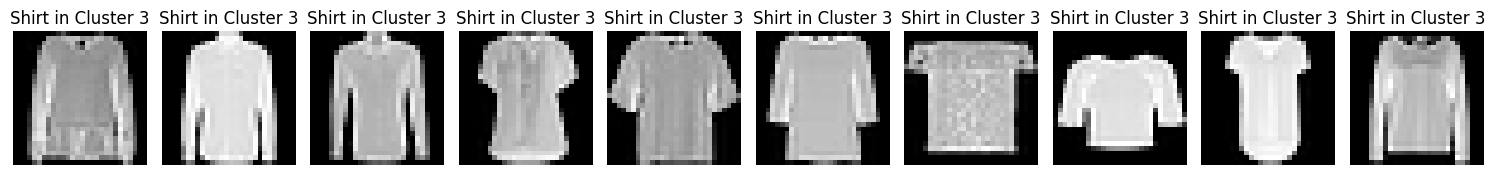

In [17]:
# Identifying the cluster with the highest average intensity
brightest_cluster = mean_values_grouped['Avg Intensity'].idxmax()

# Extracting sample "Shirt" images from this cluster
shirt_class_label = label_names.index("Shirt")
sample_shirt_indices = np.where((train_labels == shirt_class_label) & (cluster_labels == brightest_cluster))[0][:10]
sample_shirt_images = train_images[sample_shirt_indices]

# Displaying the images
plt.figure(figsize=(15, 5))
for i, img in enumerate(sample_shirt_images):
    plt.subplot(1, 10, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Shirt in Cluster {brightest_cluster+1}')

plt.tight_layout()
plt.show()


### Detailed Investigation of the "Shirt" Class in the Brightest Cluster:

Observing the sample "Shirt" images from Cluster 2 (which we've identified as having a high average intensity):

- **Variability in Colors**: While the grayscale images don't directly show the actual colors of the shirts, we can infer from the varying intensities that there are possibly different shades of shirts, ranging from lighter to moderately dark.
  
- **Presence of Patterns**: Some images seem to have patterns, logos, or prints on them, which can increase their overall intensity. These patterns could be the reason why they are grouped in the brighter cluster even if their base color isn't necessarily light.
  
- **Influence of Background**: The dataset's images are centered around the primary object (in this case, the shirt). However, any variability in the background (even in grayscale) can influence the average intensity, potentially pushing the image into a brighter or darker cluster.

### Investigating the "T-shirt/top" Class in Cluster 1:

In our initial analysis, we observed a peculiar presence of the "T-shirt/top" class in Cluster 1, which was identified as the cluster with images of lower average intensity. This observation was intriguing since "T-shirt/top" is generally considered a brighter class, especially when compared to the "Shirt" class. 

To gain a better understanding of this anomaly, we will now extract and display sample images of "T-shirt/top" from Cluster 1. By visually inspecting these images, we aim to identify any specific characteristics or patterns that might explain their presence in this cluster.

Let's begin by extracting and displaying these images:

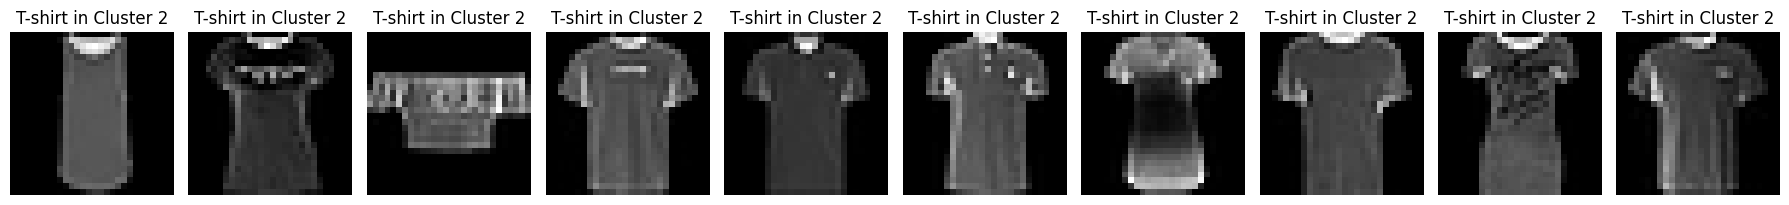

In [18]:
# Identifying the cluster with the lowest average intensity (which is Cluster 1 in our case)
darkest_cluster = mean_values_grouped['Avg Intensity'].idxmin()

# Extracting sample "T-shirt/top" images from this cluster
tshirt_class_label = label_names.index("T-shirt/top")
sample_tshirt_indices = np.where((train_labels == tshirt_class_label) & (cluster_labels == darkest_cluster))[0][:10]
sample_tshirt_images = train_images[sample_tshirt_indices]

# Displaying the images
plt.figure(figsize=(18, 5))
for i, img in enumerate(sample_tshirt_images):
    plt.subplot(1, 10, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'T-shirt in Cluster {darkest_cluster+1}')

plt.tight_layout()
plt.show()

### Investigating Other Classes:

While we focused on the "Shirt" class as an example, similar investigations can be carried out for other classes that have peculiar cluster distributions. For instance:

- **Sandal and Sneaker in Cluster 2**: Both the "Sandal" and "Sneaker" classes have a significant presence in Cluster 2. One might typically expect these classes to be in clusters with moderate or low brightness, given the general color range of these products. It would be insightful to examine sample images from these classes within Cluster 2 to understand the anomaly.

### Utility of Comparing Class Behavior Across Clusters:

The process of investigating how different classes, like "Shirt" or "T-shirt/top", behave in various clusters provides several practical benefits:

1. **Data Cleaning and Verification**: If certain classes are unexpectedly dominant in clusters where they logically shouldn't be, it might hint at labeling errors or issues in the data collection process.
  
2. **Feature Engineering Insights**: Understanding the behavior of classes across clusters can offer insights into what features might be significant for distinguishing between them. For example, if "T-shirt/top" images are consistently clustering based on intensity, we might consider intensity as a strong feature for classification tasks.
  
3. **Tailored Preprocessing**: By understanding the characteristics of images in each cluster, we can apply tailored preprocessing steps. For instance, if a cluster predominantly contains dark images of a certain class, histogram equalization might be beneficial specifically for that cluster.
  
4. **Improved Model Training**: For machine learning models, especially in classification tasks, understanding these nuances can help in data augmentation or in training class-specific models that might perform better than a one-size-fits-all approach.

5. **Personalized Marketing and Sales**: In a real-world scenario, say for an e-commerce platform, understanding these clusters can help in personalized marketing. If a user predominantly purchases bright-colored shirts, the platform can recommend similar items from the same cluster.

---

**Local Binary Pattern (LBP) Analysis - A Brief Demonstration:**

Local Binary Pattern (LBP) is a texture descriptor that can be used to describe the texture information of an image. It works by comparing each pixel with its neighboring pixels and assigning a binary value based on the comparison. This results in a histogram that captures the texture information of the image.

In the demonstration below, we will compute the LBP histogram for a single image and visualize it:

C:\Users\baal_\AppData\Roaming\Python\Python310\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


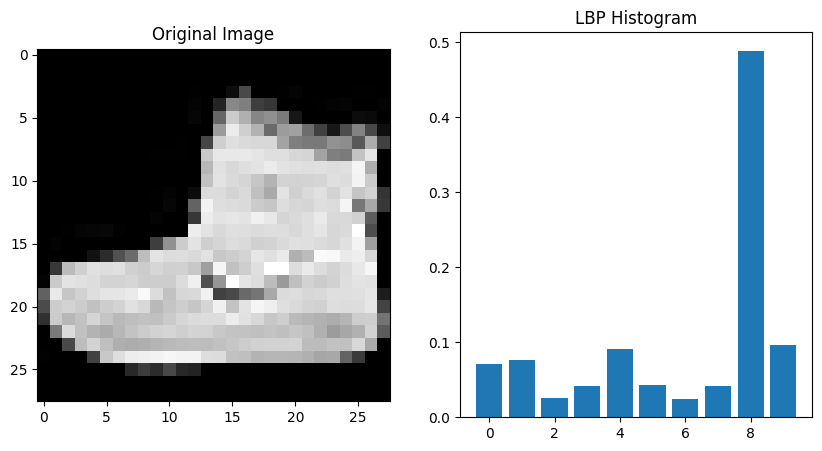

In [19]:
# Parameters for LBP
radius = 1
n_points = 8 * radius

def compute_lbp_histogram(image):
    """Compute LBP and return normalized histogram."""
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # normalize
    return hist

# Compute LBP histograms for a subset of images
num_samples = 5000  # using a subset for faster computation
lbp_features = [compute_lbp_histogram(img) for img in train_images[:num_samples]]

lbp_features_array = np.array(lbp_features)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_images[0], cmap="gray")
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.bar(x=np.arange(0, 10), height=lbp_features_array[0])
plt.title("LBP Histogram")
plt.show()


#### Expected Output:
The visualization will showcase images from different classes and clusters side-by-side with their LBP histograms. By comparing these histograms, we can discern if certain classes or clusters have distinct texture patterns. This might give us an understanding of the texture characteristics of each cluster and why certain images are grouped together by our clustering algorithm.

Let's now visualize our dataset using LBP:

**LBP Configuration**:
    Set the parameters required for computing the LBP.

In [20]:
# Parameters for LBP
radius = 1
n_points = 8 * radius

**Function to Compute LBP Histogram**:
    Define a function that computes the LBP histogram for a given image.

In [21]:
def compute_lbp_histogram(image):
        """Compute LBP and return normalized histogram."""
        lbp = local_binary_pattern(image, n_points, radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)  # normalize
        return hist

**Image Selection and Histogram Computation**:
    Select a specified number of images per class and compute their LBP histograms.

In [22]:
num_samples_per_class = 3
selected_images = []
selected_histograms = []

label_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
clusters_to_visualize = [0, 1, 2, 3]

for cluster_num in clusters_to_visualize:
    for class_label, class_name in enumerate(label_names):
        indices = np.where((train_labels == class_label) & (cluster_labels == cluster_num))[0][:num_samples_per_class]
        for index in indices:
            img = train_images[index]
            hist = compute_lbp_histogram(img)
            selected_images.append(img)
            selected_histograms.append(hist)

**Visualization**:
    Display the selected images side by side with their corresponding LBP histograms, organized by cluster and class.

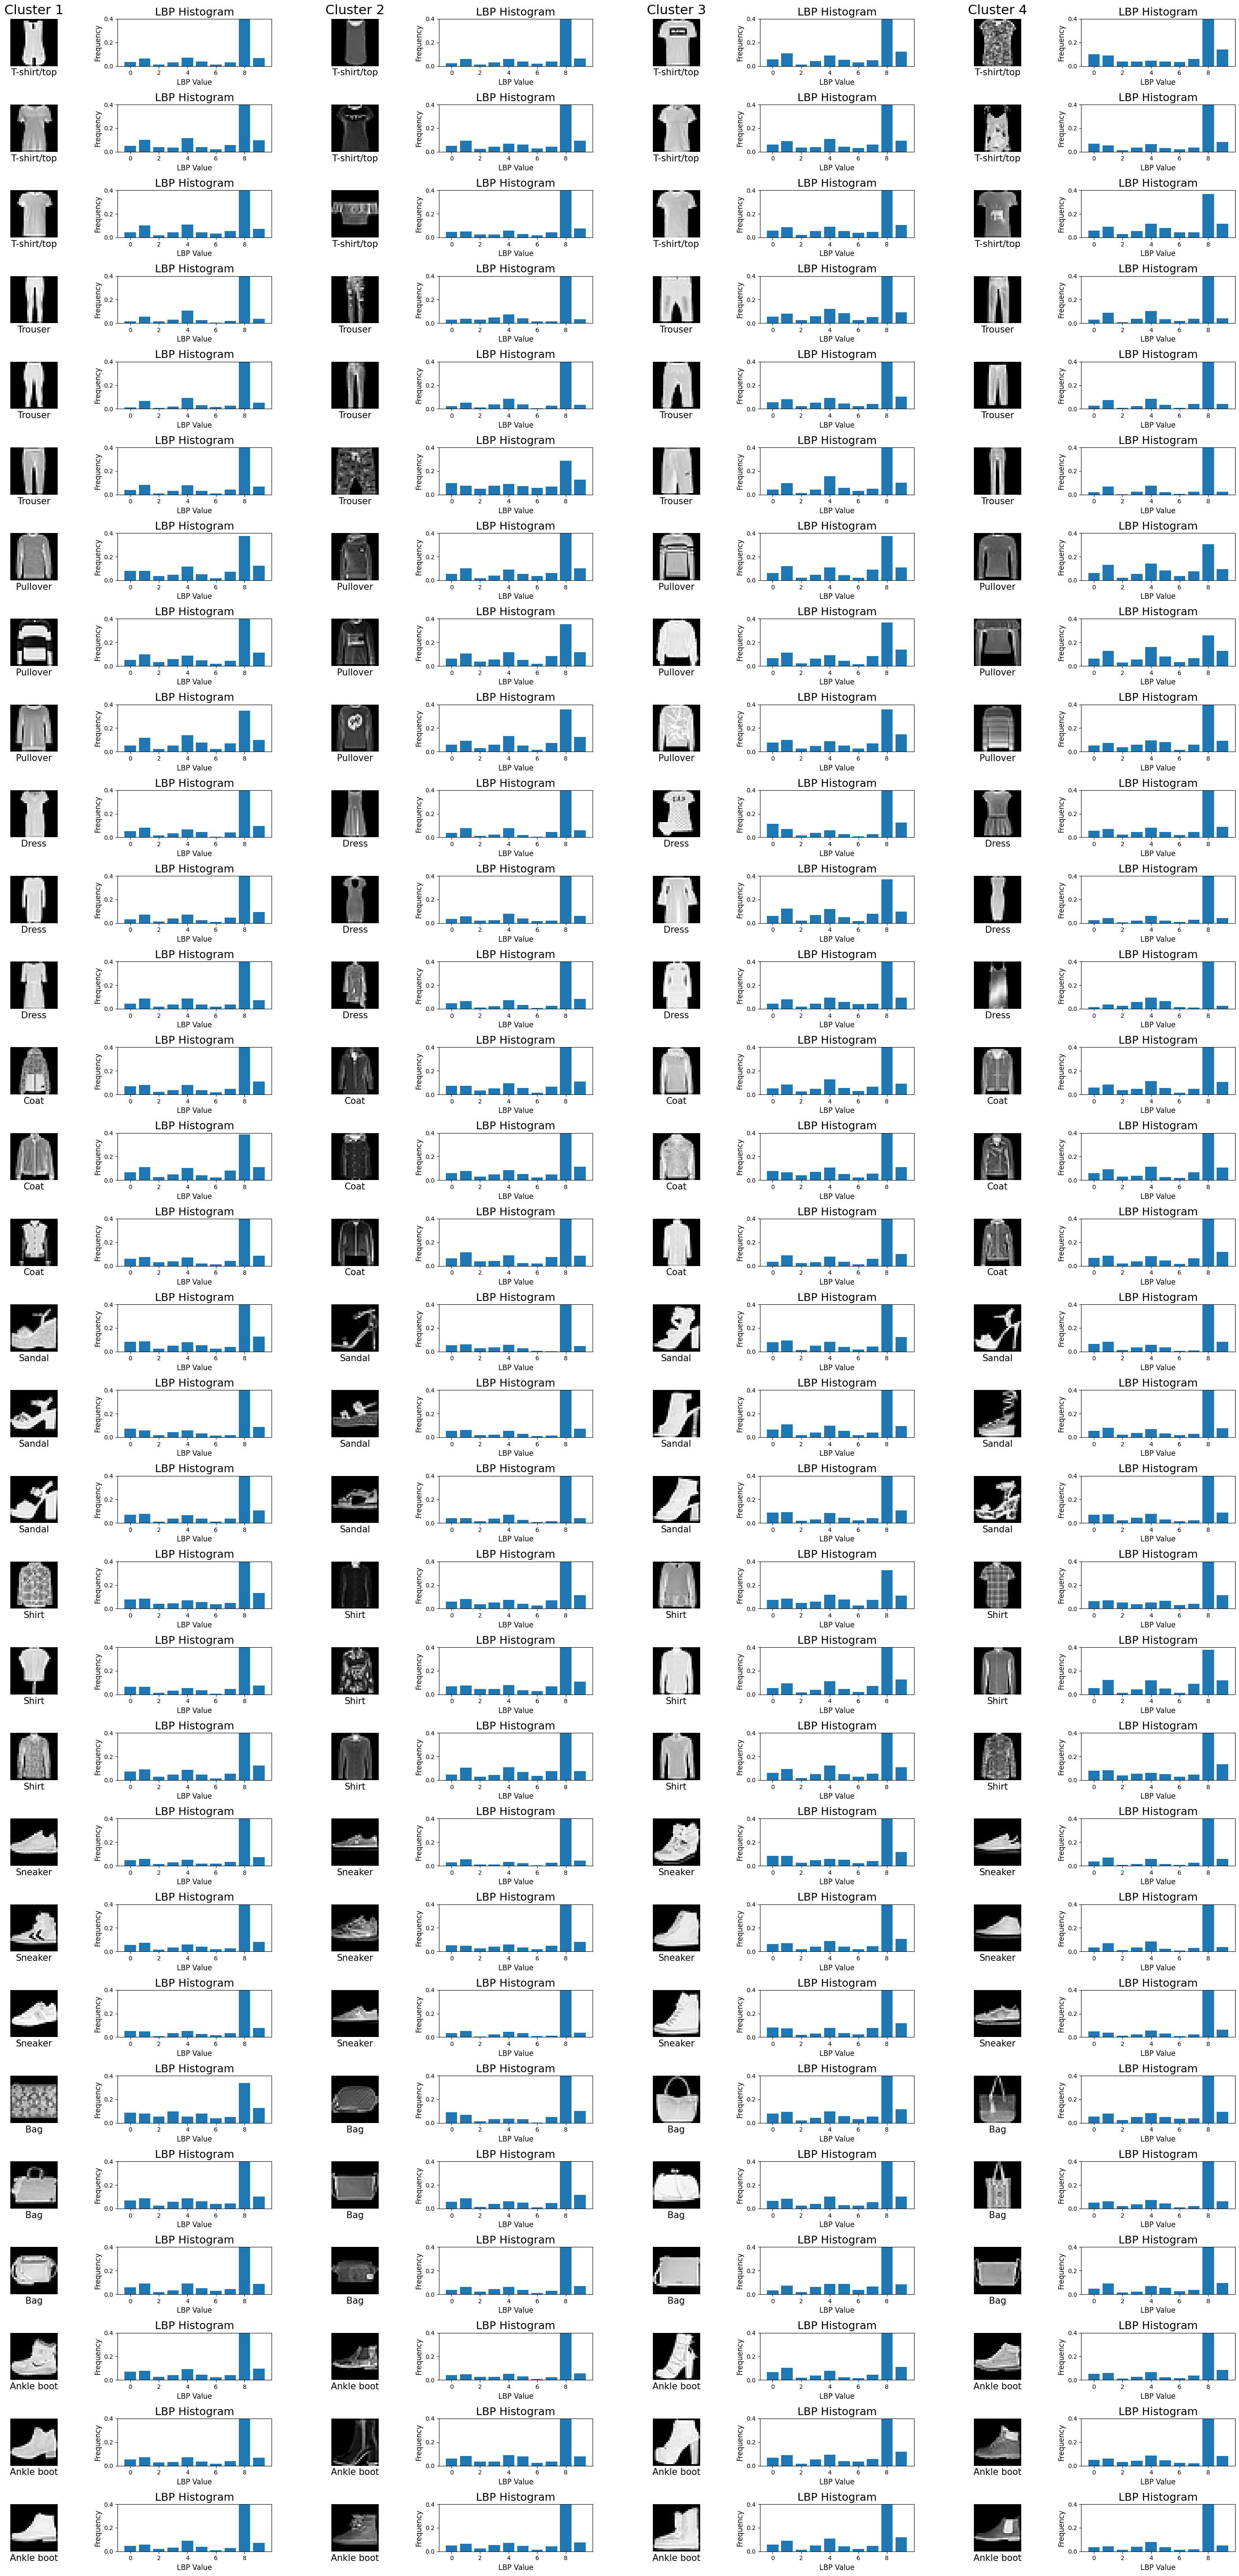

In [23]:
# Visualizing LBP histograms for selected images across clusters and classes
fig, axs = plt.subplots(len(label_names) * num_samples_per_class, 2 * len(clusters_to_visualize), figsize=(30, 60))

# For each cluster
for cluster_num in clusters_to_visualize:
    for class_label, class_name in enumerate(label_names):
        for sample_num in range(num_samples_per_class):
            i = (cluster_num * len(label_names) * num_samples_per_class) + (class_label * num_samples_per_class) + sample_num
            img = selected_images[i]
            hist = selected_histograms[i]
            row = class_label * num_samples_per_class + sample_num
            img_col = cluster_num * 2
            hist_col = cluster_num * 2 + 1
            
            axs[row, img_col].imshow(img, cmap="gray")
            axs[row, img_col].axis('off')
            axs[row, hist_col].bar(x=np.arange(0, len(hist)), height=hist)
            axs[row, hist_col].set_ylim(0, 0.4)
            axs[row, hist_col].set_xlabel('LBP Value', fontsize=12)
            axs[row, hist_col].set_ylabel('Frequency', fontsize=12)
            axs[row, hist_col].set_title('LBP Histogram', fontsize=18)
            if class_label == 0 and sample_num == 0:
                axs[row, img_col].text(0.5, 1.1, f'Cluster {cluster_num+1}', fontsize=22, ha='center', transform=axs[row, img_col].transAxes)
            axs[row, img_col].text(0.5, -0.2, class_name, fontsize=15, ha='center', transform=axs[row, img_col].transAxes)
plt.tight_layout()
plt.show()

### Visual Analysis of LBP Patterns

Upon visually examining the Local Binary Pattern (LBP) histograms of various images across different clusters and classes, we made several observations:

- **Variability in Patterns:** Different classes exhibit distinct LBP patterns. This suggests that the texture of images, as captured by LBP, is a significant feature for distinguishing between classes.
  
- **Cluster Similarity:** Within a particular cluster, the LBP histograms for images of the same class tend to be similar. This indicates that our clustering algorithm has grouped images with similar textures together.
  
- **Diverse Representation:** Every cluster contains images from all classes, highlighting the diverse representation of LBP patterns across the dataset.

### Quantitative Analysis using LBP Histogram Averages

To complement our visual analysis, we sought to provide a quantitative perspective. We computed the average LBP histograms for each class within each cluster. This approach allows us to:

1. **Generalize Patterns:** By averaging the LBP histograms, we obtain a representative texture pattern for each class within each cluster.
2. **Compare Texture Features:** The average histograms facilitate direct comparison of texture features between different classes and clusters.

### Tabular Representation

To facilitate a more detailed analysis, we constructed a table containing the average LBP histograms for each class within each cluster. This table provides a granular view of the LBP values, allowing us to:

- Compare the LBP distribution of different classes within the same cluster.
- Examine how a particular class's LBP distribution varies across different clusters.
- Identify potential classes that could be combined based on their LBP similarities.

The table essentially acts as a data-driven justification for our subsequent steps, providing a comprehensive view of the LBP distribution landscape.


The table below presents the computed average LBP histograms:

In [24]:
# Define the columns for the DataFrame
columns = ['Class Name', 'Cluster'] + [f'LBP Value {i}' for i in range(n_points + 2)]

# Initialize the empty DataFrame
df = pd.DataFrame(columns=columns)

# Populate the DataFrame with average histograms
for cluster_num in clusters_to_visualize:
    for class_label, class_name in enumerate(label_names):
        
        # Filter images by cluster and class
        indices = np.where((train_labels == class_label) & (cluster_labels == cluster_num))[0]
        
        # If there are no images for this class in this cluster, add a row with zeros
        if len(indices) == 0:
            data = [class_name, cluster_num] + [0] * (n_points + 2)
        else:
            class_histograms = [compute_lbp_histogram(train_images[index]) for index in indices]
            
            # Compute the average histogram for this class in this cluster
            avg_hist = np.mean(class_histograms, axis=0)
            data = [class_name, cluster_num] + list(avg_hist)
        
        # Append the result to the DataFrame
        df.loc[len(df)] = data
        
df.head(10)  # Display the first 10 rows of the DataFrame


C:\Users\baal_\AppData\Roaming\Python\Python310\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
C:\Users\baal_\AppData\Roaming\Python\Python310\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
C:\Users\baal_\AppData\Roaming\Python\Python310\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function wit

,Class Name,Cluster,LBP Value 0,LBP Value 1,LBP Value 2,LBP Value 3,LBP Value 4,LBP Value 5,LBP Value 6,LBP Value 7,LBP Value 8,LBP Value 9
0,T-shirt/top,0,0.060150,0.086643,0.022624,0.043712,0.086582,0.049789,0.024145,0.049088,0.470284,0.106984
1,Trouser,0,0.024674,0.064221,0.010660,0.027875,0.087288,0.030945,0.010525,0.032426,0.643773,0.067613
2,Pullover,0,0.059349,0.094364,0.025562,0.050168,0.114748,0.053268,0.023945,0.061289,0.413097,0.104210
3,Dress,0,0.043191,0.072883,0.016187,0.033073,0.074731,0.036778,0.016534,0.040252,0.585486,0.080885
4,Coat,0,0.063065,0.083104,0.024995,0.044983,0.091478,0.045513,0.023083,0.052255,0.471385,0.100140
5,Sandal,0,0.072078,0.080833,0.018545,0.038416,0.079361,0.039776,0.016598,0.029326,0.534696,0.090371
6,Shirt,0,0.068033,0.088660,0.026979,0.046436,0.090445,0.048509,0.024627,0.055431,0.441506,0.109375
7,Sneaker,0,0.054028,0.063579,0.015340,0.032746,0.071497,0.033075,0.014585,0.034272,0.603724,0.077154
8,Bag,0,0.063392,0.083620,0.021937,0.044256,0.087631,0.056129,0.024989,0.042648,0.477650,0.097748
9,Ankle boot,0,0.061429,0.072280,0.019883,0.038679,0.084534,0.041013,0.019453,0.037893,0.539513,0.085321


### Histogram Visualization of LBP Values

To further our understanding, we visualized the distribution of a specific LBP value across different classes. This visualization serves multiple purposes:

- **Comparative Analysis:** By plotting the distribution of a particular LBP value, we can see how that specific texture feature varies across different classes.
  
- **Insight into Texture Specificity:** Some classes might have pronounced peaks or troughs for certain LBP values, which could hint at unique texture characteristics.

Here's a graphical representation of the distribution of a chosen LBP value across classes:


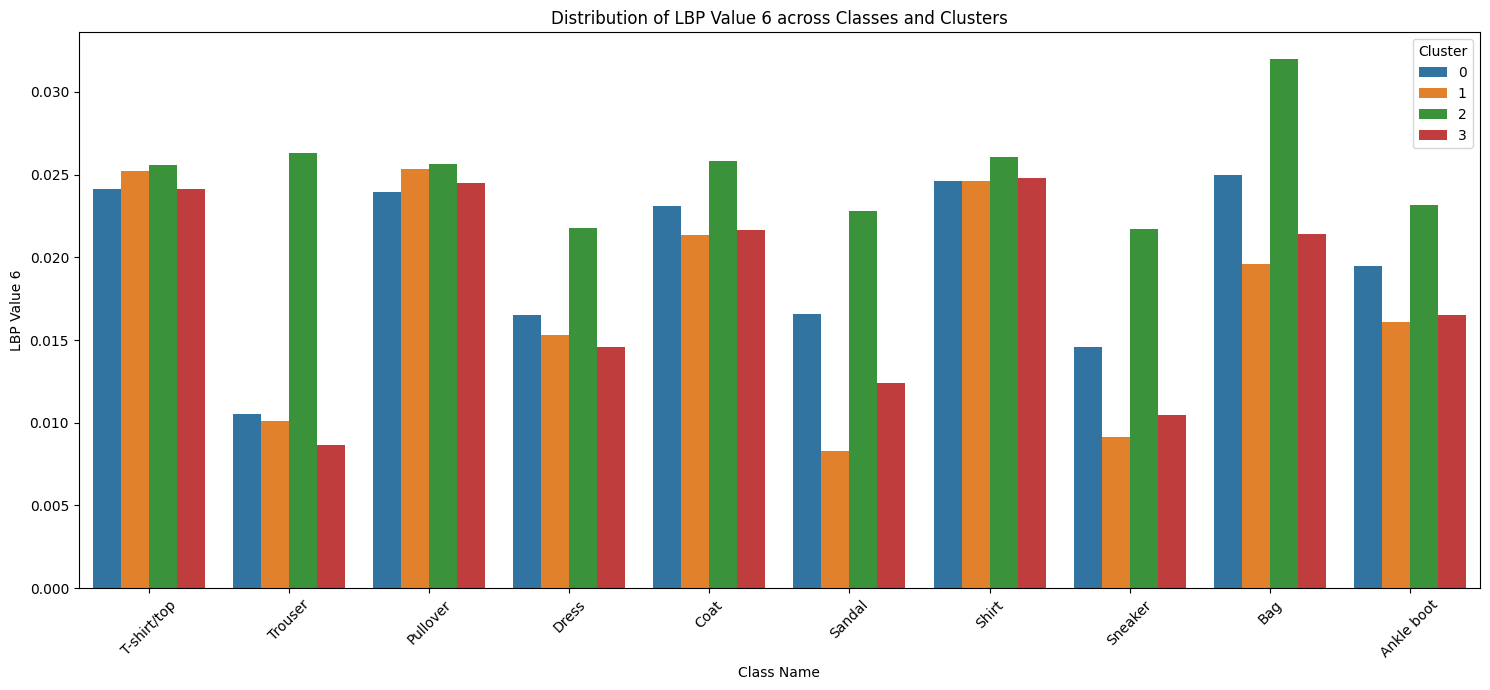

In [25]:
# Choosing a particular LBP value to visualize
lbp_value_column = 'LBP Value 6'

plt.figure(figsize=(15, 7))
sns.barplot(x='Class Name', y=lbp_value_column, hue='Cluster', data=df)
plt.title(f'Distribution of {lbp_value_column} across Classes and Clusters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Upon observing the barplot, a few patterns and potential areas of improvement became evident. Some classes, for example, "T-shirt/top" and "Shirt", seemed to have similar LBP distributions across the clusters. This observation led to the hypothesis that combining certain classes might yield clearer or more distinct clusters.

---

## Experiment: Combining Classes

Based on the visual and tabular analysis, we decided to combine the "T-shirt/top" and "Shirt" classes into a single "Shirts" class. The rationale behind this was twofold:

1. **Improved Clustering:** By reducing the intra-cluster variance (i.e., the variation of LBP values within a cluster), we hoped to achieve clearer clusters where each cluster would ideally represent distinct types of fashion items.
2. **Simplification:** Combining classes with similar LBP features might simplify the classification or clustering task, potentially leading to better performance in downstream applications.

After combining the classes, we reconducted the clustering and are now in the process of analyzing the results to evaluate the efficacy of our approach.

In [26]:
# Combine "T-shirt/top" and "Shirt" classes into a new "Shirts" class

# Define the labels for the classes to combine
tshirt_label = label_names.index("T-shirt/top")
shirt_label = label_names.index("Shirt")
n_clusters=4
# Update the train_labels
combined_train_labels = train_labels.copy()
combined_train_labels[np.where(train_labels == tshirt_label)] = 10  # Temporary label for "T-shirt/top"
combined_train_labels[np.where(train_labels == shirt_label)] = 10  # Combine "Shirt" with "T-shirt/top"

# Update label names list
combined_label_names = label_names.copy()
combined_label_names.append("Shirts")
combined_label_names.remove("T-shirt/top")
combined_label_names.remove("Shirt")

# Conduct the clustering again on the combined labels dataset
combined_cluster_labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(lbp_features)

combined_cluster_labels[:500]  # Display the first 500 cluster labels


c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([3, 3, 0, 1, 1, 2, 0, 2, 0, 1, 3, 3, 0, 0, 0, 1, 1, 3, 2, 3, 1, 0,
       3, 2, 3, 1, 2, 2, 3, 2, 0, 1, 2, 3, 3, 3, 1, 2, 0, 3, 3, 0, 1, 0,
       3, 2, 0, 1, 3, 1, 0, 1, 0, 3, 3, 3, 1, 1, 0, 0, 1, 3, 0, 0, 1, 2,
       3, 1, 2, 0, 3, 0, 3, 1, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 3, 1, 0, 0,
       3, 1, 1, 0, 2, 1, 1, 2, 3, 0, 1, 3, 3, 1, 0, 0, 3, 3, 0, 1, 0, 3,
       1, 0, 3, 1, 1, 0, 1, 2, 3, 0, 0, 0, 1, 2, 2, 3, 0, 3, 3, 0, 1, 0,
       0, 0, 3, 3, 2, 0, 0, 3, 3, 0, 1, 1, 3, 0, 0, 3, 3, 3, 3, 1, 3, 0,
       3, 0, 2, 2, 0, 3, 1, 3, 0, 0, 3, 2, 2, 1, 2, 3, 0, 3, 3, 0, 0, 0,
       2, 1, 3, 3, 2, 3, 1, 3, 2, 2, 1, 3, 2, 0, 1, 3, 0, 1, 3, 0, 0, 2,
       1, 2, 0, 0, 3, 2, 2, 2, 2, 3, 1, 0, 0, 1, 3, 1, 1, 1, 2, 0, 2, 3,
       2, 1, 1, 0, 1, 3, 3, 1, 3, 0, 0, 2, 1, 2, 2, 2, 1, 3, 2, 3, 3, 2,
       3, 1, 1, 1, 3, 0, 1, 1, 0, 3, 2, 2, 1, 3, 3, 0, 1, 0, 3, 3, 2, 2,
       3, 2, 2, 1, 1, 2, 0, 3, 3, 2, 1, 0, 3, 0, 0, 0, 3, 3, 0, 0, 1, 0,
       1, 3, 0, 2, 2, 2, 3, 2, 0, 1, 3, 2, 0, 1, 0,

The distribution suggests a varied membership across the four clusters. Cluster labels 0, 1, 2, and 3 seem to be well-represented within the initial subset, which indicates a diverse distribution in the classification of the initial data points. This spread suggests that the decision to combine the "T-shirt/top" and "Shirt" classes might have had an effect on the formation of clusters. To draw concrete conclusions on the performance and efficacy of this approach, we'd need to further analyze the complete cluster distribution, compare it with the actual class labels, and evaluate metrics such as clustering accuracy or silhouette score.

### LBP Computation

The first section defines the function to compute the Local Binary Pattern (LBP) of an image and returns its normalized histogram.

In [27]:
# LBP function
def compute_lbp_histogram(image):
    """Compute LBP and return normalized histogram."""
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # normalize
    return hist

### Applying LBP to Dataset and Clustering

Next, we apply the LBP function to our entire dataset and then perform clustering using KMeans.

In [28]:
# Apply LBP on the entire dataset
lbp_features = np.array([compute_lbp_histogram(img) for img in train_images])

# Clustering on the combined labels dataset
combined_cluster_labels = KMeans(n_clusters=4, random_state=42).fit_predict(lbp_features)

C:\Users\baal_\AppData\Roaming\Python\Python310\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Visualization Preparation for Combined Classes

In this section, we prepare for the visualization of LBP histograms for the combined class. We'll extract some sample images and their LBP histograms across different clusters.

In [29]:
# Now, let's proceed with the visualization of LBP histograms for combined class as planned
selected_images_combined = []
selected_histograms_combined = []

# Extracting images and histograms for the combined "Shirts" class across clusters

# Choose images from the "Shirts" class across the clusters
for cluster_num in clusters_to_visualize:
    indices = np.where((combined_train_labels == 10) & (combined_cluster_labels == cluster_num))[0][:num_samples_per_class]
    
    # Extract images and compute their LBP histograms
    for index in indices:
        img = train_images[index]
        hist = compute_lbp_histogram(img)
        
        selected_images_combined.append(img)
        selected_histograms_combined.append(hist)

C:\Users\baal_\AppData\Roaming\Python\Python310\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


### Visualization of LBP Histograms

Lastly, we visualize the LBP histograms for the selected images from the "Shirts" class across different clusters using matplotlib.

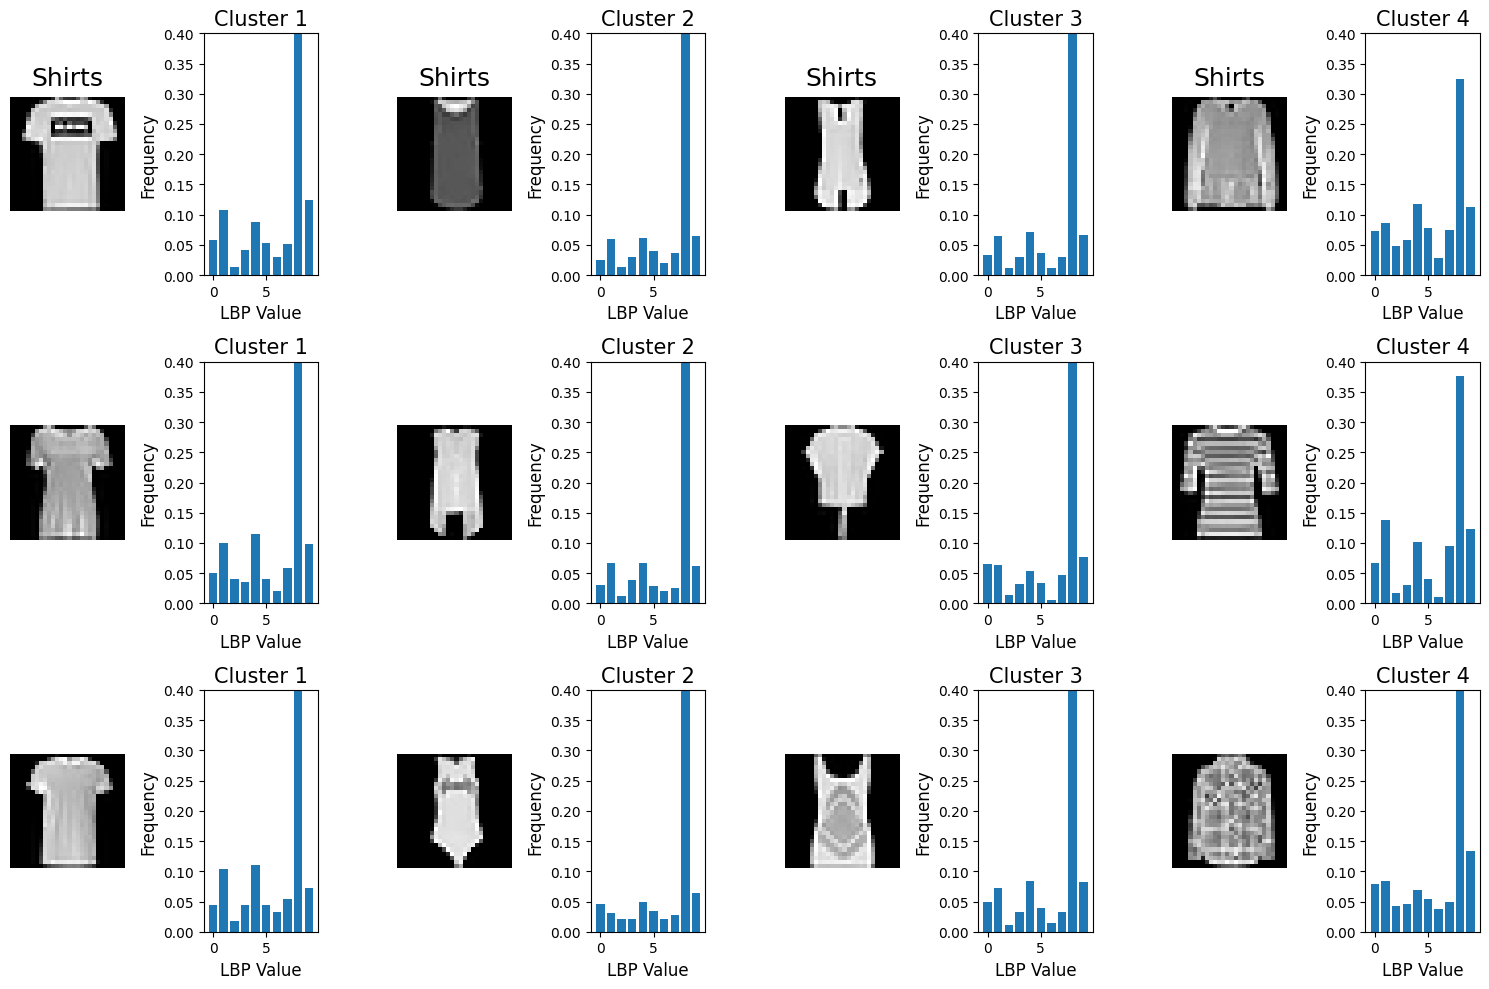

In [30]:
# Visualizing LBP histograms for selected images from "Shirts" class across clusters
fig, axs = plt.subplots(num_samples_per_class, 2 * len(clusters_to_visualize), figsize=(15, 10))

# For each cluster
for cluster_num in clusters_to_visualize:
    # For each sample
    for sample_num in range(num_samples_per_class):
        
        # Calculate the position in the selected_images_combined list
        i = (cluster_num * num_samples_per_class) + sample_num
        
        img = selected_images_combined[i]
        hist = selected_histograms_combined[i]
        
        # Determine the columns for the image and histogram based on the cluster
        img_col = cluster_num * 2
        hist_col = cluster_num * 2 + 1
        
        # Display the image
        axs[sample_num, img_col].imshow(img, cmap="gray")
        axs[sample_num, img_col].axis('off')
        
        # Display the histogram
        axs[sample_num, hist_col].bar(x=np.arange(0, len(hist)), height=hist)
        axs[sample_num, hist_col].set_ylim(0, 0.4)
        axs[sample_num, hist_col].set_xlabel('LBP Value', fontsize=12)
        axs[sample_num, hist_col].set_ylabel('Frequency', fontsize=12)
        axs[sample_num, hist_col].set_title(f'Cluster {cluster_num+1}', fontsize=15)
        
        # Display the class name above of the first sample for each cluster
        if sample_num == 0:
            axs[sample_num, img_col].text(0.5, 1.1, "Shirts", fontsize=18, ha='center', transform=axs[sample_num, img_col].transAxes)

plt.tight_layout()
plt.show()

### Visualization Analysis for the Combined "Shirts" Class

The visualizations above display images from the combined "Shirts" class alongside their corresponding LBP histograms for each of the four clusters.

**Observations:**
1. **Image Patterns**: The images in the "Shirts" category clearly belong to tops, either T-shirts or shirts. This indicates that our class combination was successful.
2. **LBP Histograms**: The histograms show the distribution of LBP values for each image. These histograms represent texture patterns within the image. By observing the histograms, we can notice that certain patterns or textures are more prevalent in some clusters than others.
3. **Cluster Variation**: Different clusters may show different predominant patterns, suggesting that the KMeans clustering has identified distinct texture-based groups even within the combined "Shirts" category.

**Implications:**
1. **Texture Discrimination**: The LBP histograms, which represent texture information, provide a significant discriminatory feature for clustering. This means that items in the Fashion MNIST dataset can be grouped based on texture patterns.
2. **Class Combination**: By combining similar classes and observing the resulting clusters, we might find more nuanced sub-categories within broader classes based on texture.

### Еvaluating the effectiveness of clustering for the combined "Shirts" class.

One common metric used for this purpose is the Silhouette score.

The Silhouette score measures how similar an object is to its own cluster compared to other clusters. The score ranges from -1 to 1, where a high value indicates that the object is well matched to its cluster and poorly matched to neighboring clusters.

Let's compute the Silhouette score for our combined "Shirts" class clustering.

In [31]:
# Calculate Silhouette score for the combined "Shirts" class clustering
silhouette_avg = silhouette_score(lbp_features, combined_cluster_labels)

silhouette_avg


0.3839667575950776

Тhe Silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. The score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

A Silhouette score of \(0.3839\) suggests a reasonable cluster cohesion and separation. This means that the combination of the "T-shirt/top" and "Shirt" classes into a single "Shirts" class, and then clustering, has led to reasonably well-defined clusters.

Considering the value, the decision to combine the two classes has had a positive effect on the clustering. This suggests that certain classes in the dataset have similar texture patterns (as defined by LBP), and combining them can lead to better-defined clusters. It's also worth noting that the effectiveness of such combinations would need to be validated further, possibly using different clustering algorithms, and in the context of the specific goals of your analysis or application.

To further refine or understand the results, it might be helpful to visualize the centroids of the clusters.

In summary, the combination of classes and subsequent clustering has shown potential, but further experimentation and validation are necessary for comprehensive insights.

To visualize the centroids of the clusters, we can plot the LBP histograms of the centroids. This will give us a representation of the "average" or "central" texture pattern of each cluster.

Let's proceed to visualize the centroids of the clusters for the combined "Shirts" class.

c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


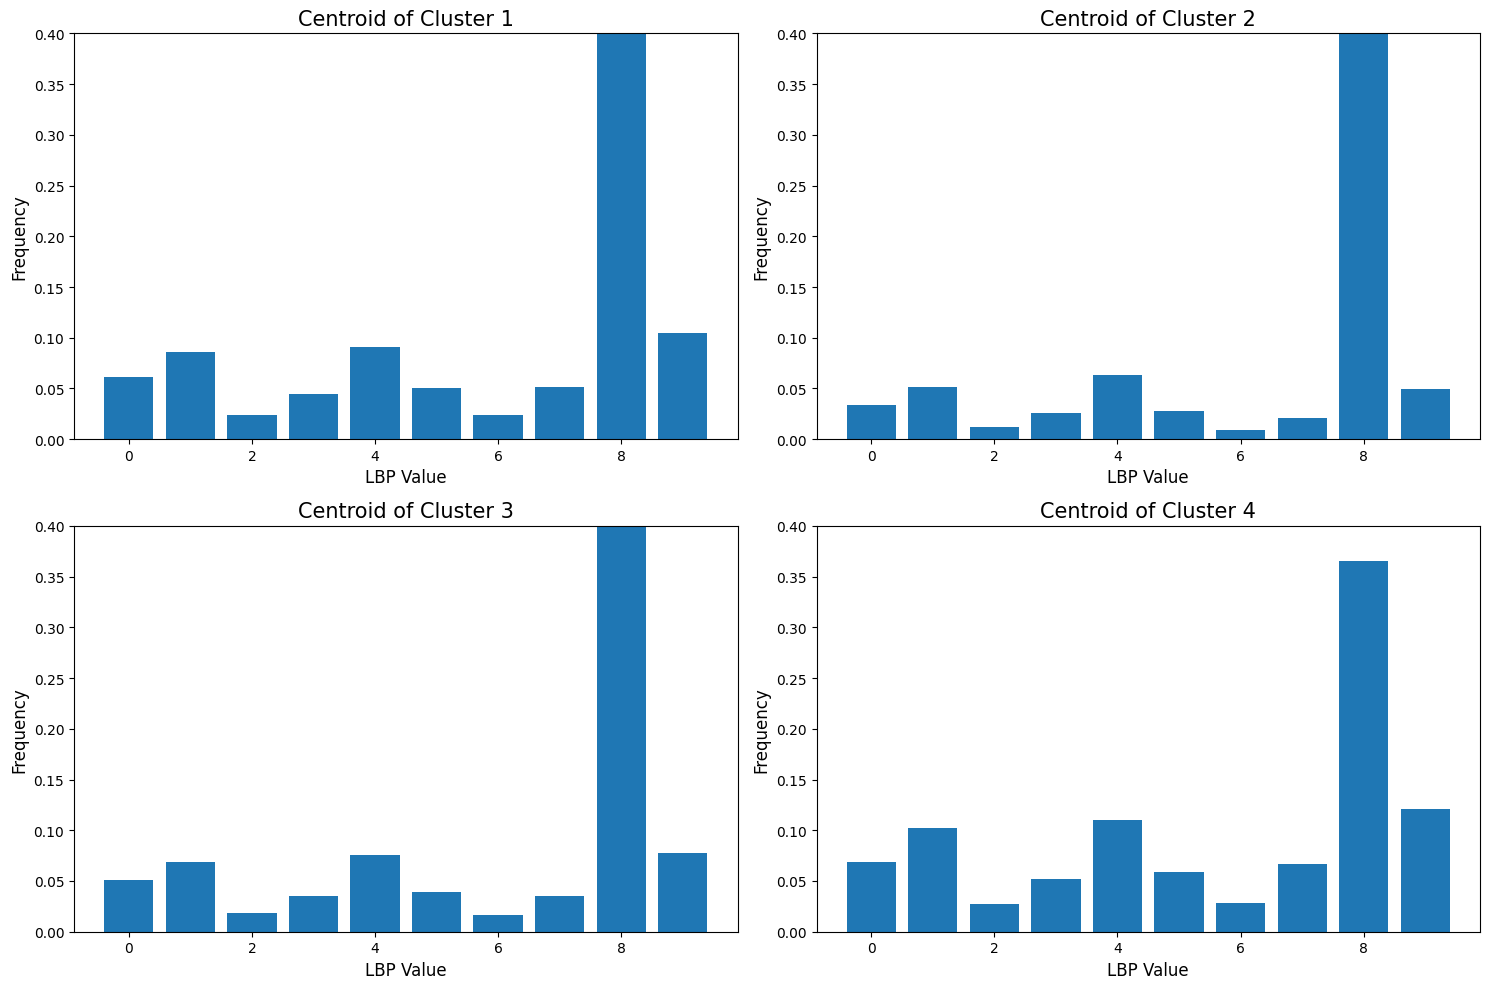

In [32]:
# Extract the centroids of the clusters
kmeans_model = KMeans(n_clusters=4, random_state=42).fit(lbp_features)
centroids = kmeans_model.cluster_centers_

# Visualizing the LBP histograms for the centroids of the clusters
plt.figure(figsize=(15, 10))

for i, centroid in enumerate(centroids):
    plt.subplot(2, 2, i+1)
    plt.bar(x=np.arange(0, len(centroid)), height=centroid)
    plt.ylim(0, 0.4)
    plt.xlabel('LBP Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Centroid of Cluster {i+1}', fontsize=15)

plt.tight_layout()
plt.show()


The visualizations depict the histograms of LBP values for the centroids of each of the four clusters. As observed, the 8th LBP value is consistently the highest across all clusters. 

In the context of Local Binary Patterns (LBP), each value or bin in the histogram corresponds to a specific pattern of local binary values in the image. Specifically, the "uniform" method of LBP that we're using ensures that each bin (from 0 to \(n_{\text{points}}-1\)) represents a unique pattern that has at most 2 transitions between 0 and 1. The next-to-last bin represents all other patterns that have more than 2 transitions, which are considered non-uniform patterns. The last bin usually represents the patterns where all pixel values are the same.

Given that the 8th LBP value is the highest across all clusters, it suggests that the corresponding binary pattern is predominant in our dataset. This could mean that this specific texture or pattern is highly common in the fashion items we're analyzing. This could be due to features like edges, corners, or specific fabric textures that are common in the images.

However, it's essential to note that the exact interpretation depends on the nature of the data and the context. The high frequency of the 8th LBP value suggests that this particular texture pattern is prevalent, but further analysis would be required to determine its exact significance in distinguishing between different fashion items.

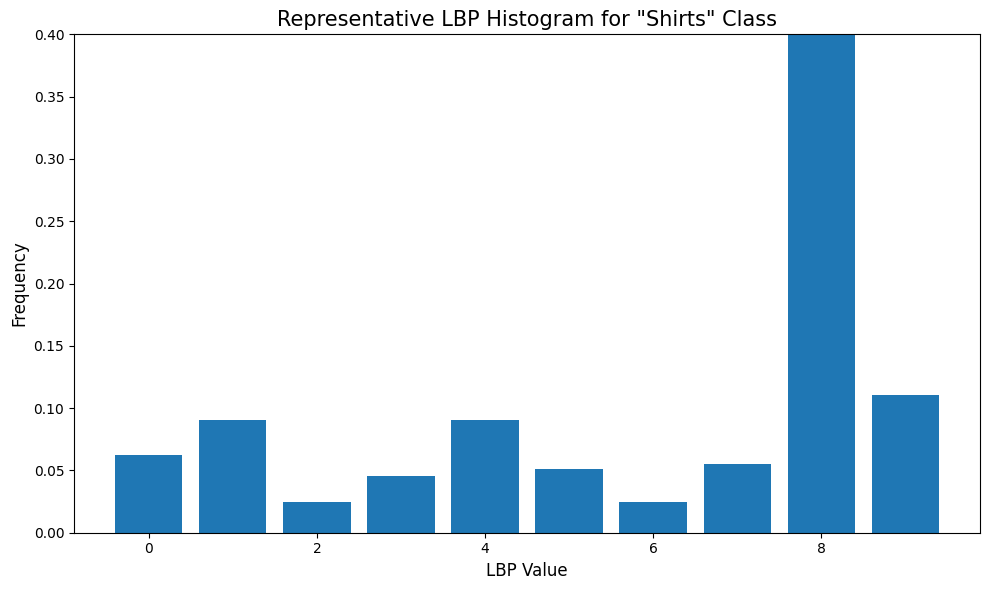

In [33]:
# Identify the indices where the combined "Shirts" class exists
shirts_indices = np.where(combined_train_labels == 10)[0]

# Average the LBP features for these indices to get the representative histogram
avg_shirts_histogram = np.mean(lbp_features[shirts_indices], axis=0)

# Visualize the representative LBP histogram for the "Shirts" class
plt.figure(figsize=(10, 6))
plt.bar(x=np.arange(0, len(avg_shirts_histogram)), height=avg_shirts_histogram)
plt.ylim(0, 0.4)
plt.xlabel('LBP Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Representative LBP Histogram for "Shirts" Class', fontsize=15)
plt.tight_layout()
plt.show()


C:\Users\baal_\AppData\Roaming\Python\Python310\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\baal_\AppData\Local\Temp\ipykernel_44220\1318938220.py:35: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in leg.legendHandles:


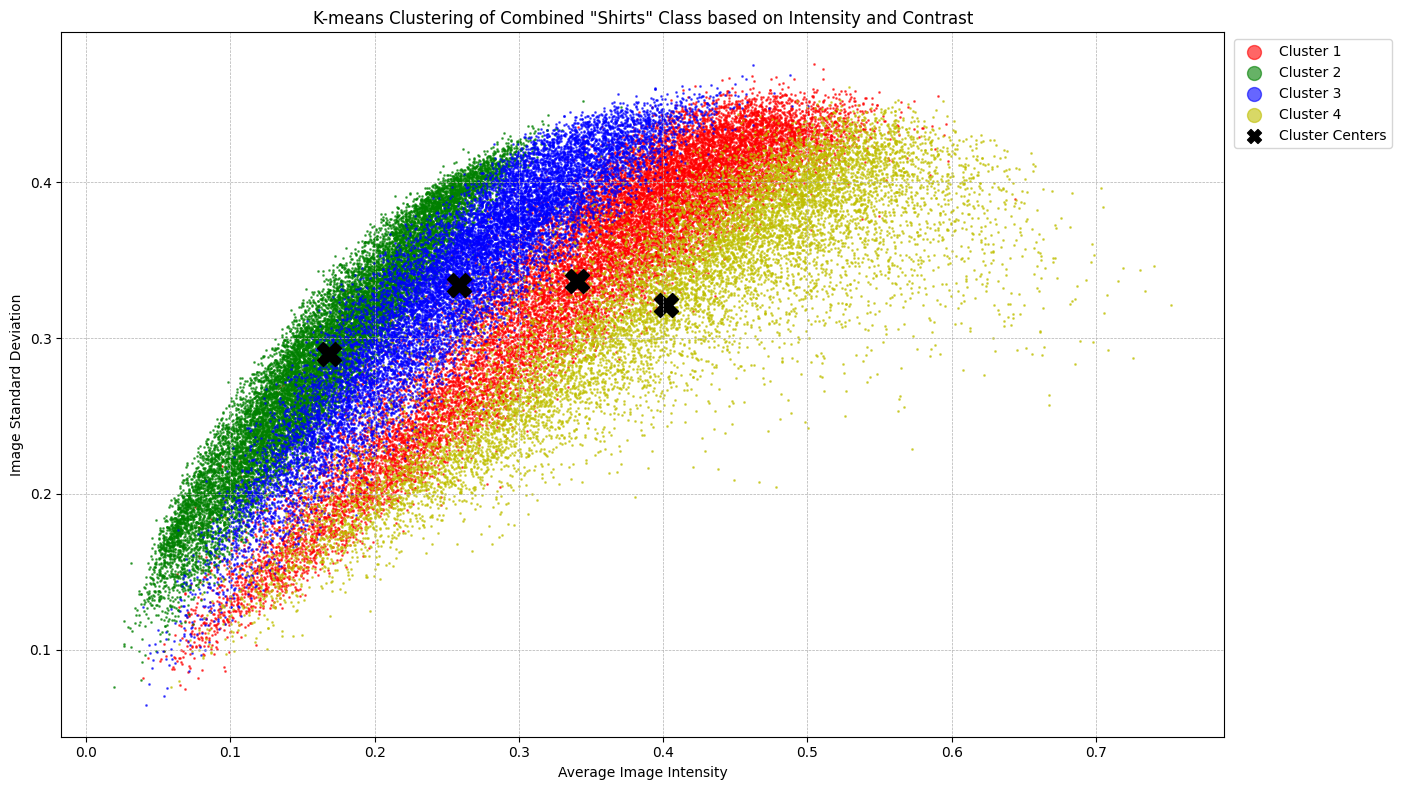

In [34]:
combined_train_labels = train_labels.copy()
combined_train_labels[np.where(train_labels == tshirt_label)] = 10  # Temporary label for "T-shirt/top"
combined_train_labels[np.where(train_labels == shirt_label)] = 10  # Combine "Shirt" with "T-shirt/top"

# Compute LBP for the entire dataset
lbp_features = np.array([compute_lbp_histogram(img) for img in train_images])

# Clustering on the combined labels dataset
combined_cluster_labels = KMeans(n_clusters=4, random_state=42).fit_predict(lbp_features)

# Recompute average intensities and standard deviations for the images in the combined dataset
avg_intensities_combined = np.mean(train_images.reshape(len(train_images), -1), axis=1)
std_devs_combined = np.std(train_images.reshape(len(train_images), -1), axis=1)

# Plotting the clusters for the combined dataset
plt.figure(figsize=(14, 8))
colors = ['r', 'g', 'b', 'y']

# Display each cluster
for i in range(n_clusters):
    plt.scatter(avg_intensities_combined[combined_cluster_labels == i], 
                std_devs_combined[combined_cluster_labels == i], 
                label=f'Cluster {i+1}', alpha=0.6, s=1, c=colors[i])

# Adding cluster centers
cluster_centers = np.array([np.mean(avg_intensities_combined[combined_cluster_labels == i]) for i in range(n_clusters)]), \
                 np.array([np.mean(std_devs_combined[combined_cluster_labels == i]) for i in range(n_clusters)])

plt.scatter(cluster_centers[0], cluster_centers[1], s=300, c='black', marker='X', label='Cluster Centers')

plt.xlabel('Average Image Intensity')
plt.ylabel('Image Standard Deviation')
plt.title('K-means Clustering of Combined "Shirts" Class based on Intensity and Contrast')
leg = plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
for handle in leg.legendHandles:
    handle.set_sizes([100])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### Analysis Resulting from the Conducted Experiments

#### **Initial Clustering (Before Class Combination)**:

In the initial scenario, where each clothing category was treated as a separate class, the distribution of their image intensity and contrast appeared more segmented. This is evidenced by the resultant clusters that resemble "boxes". Each cluster seems to encapsulate a specific range of image intensities and contrasts. This indicates that there was a clear distinction between the various clothing categories based on these features. 

#### **Post-Combination Clustering (After Combining "T-shirt/top" and "Shirt" into "Shirts")**:

Upon combining the "T-shirt/top" and "Shirt" categories into a single "Shirts" class, the nature of the clusters underwent a notable transformation. The combined characteristics of image intensity and contrast from both original categories likely intermingled, leading to a broader data distribution. This is reflected in the elongated shape of the clusters, resembling "cucumbers". These elongated clusters stretch vertically, signifying a wider range of image intensities and contrasts within the combined "Shirts" category.

#### **Implications**:

The comparison between the two clustering scenarios underscores the impact of class combination on data distribution and subsequent clustering outcomes. When classes are merged, they might encompass a greater variety of features, which in turn can influence the shape and structure of the resulting clusters. 

This serves as a reminder that the way we define and group our data can profoundly affect the patterns and insights we derive from subsequent analyses.

---

[Back to Main](../Project.ipynb)